In [111]:
from lineage_motif.plot import *
from lineage_motif.resample import *
from lineage_motif.simulate import *

from Bio import Phylo
from Bio.Phylo.BaseTree import TreeMixin
import io

from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

pyplot.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['figure.dpi'] = 300
pd.set_option('display.max_rows', 100)
pyplot.rcParams["font.family"] = "Arial"

In [380]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

def _annot(number):
    if number < 0.0005:
        return '***'
    elif number < 0.005:
        return '**'
    elif number < 0.05:
        return '*'

subtree_type_list = ['doublet',
                     'triplet',
                     'quartet', 
                     'sextet',
                     'octet',
                     'asym_quartet',
                     'asym_quintet',
                     'asym_sextet',
                     'asym_septet'
                     ]

index_list = [[1,3], 
              [1,4,6], 
              [2,4,8,10], 
              [2,4,9,11,15,17],
              [3,5,9,11,17,19,23,25],
              [1,4,7,9], 
              [1,4,7,10,12], 
              [1,4,7,10,13,15], 
              [1,4,7,10,13,16,18]
              ]

y_list = [[-0.06, -0.15], 
          [-0.06, -0.18, -0.27],
          [-0.06, -0.15, -0.27, -0.36],
          [-0.06, -0.15, -0.27, -0.36, -0.45, -0.54],
          [-0.06, -0.15, -0.24, -0.33, -0.45, -0.54, -0.63, -0.72],
          [-0.06, -0.18, -0.30, -0.39],
          [-0.06, -0.18, -0.30, -0.42, -0.51],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.63],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.66, -0.75],
         ]

labelpad_list = [22.5, 40, 47.5, 80, 95, 60, 80, 100, 120]

df_annotations = pd.DataFrame({'subtree_type': subtree_type_list,
                               'index': index_list,
                               'y': y_list,
                               'labelpad': labelpad_list})

def _make_annotation(cell_color_dict, ax, label, subtree_type):
    index_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['index'].values[0]
    y_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['y'].values[0]

    for index, y in zip(index_list_subtree, y_list_subtree):
        c_str = label[index]
        x = label
        ax.add_artist(_make_circle(cell_color_dict[c_str], 4.5, x, y, 0.4))
        ax.annotate(c_str, 
                    xy=(x, y), 
                    verticalalignment="center", 
                    horizontalalignment="center",
                    annotation_clip=False, 
                    xycoords=("data", "axes fraction"),
                    **{'fontname':'Arial', 'size':8})

def plot_deviation(subtree, 
                   df_true_melt_subset, 
                   df_null_zscores_i_c_melt_subset, 
                   df_null_zscores_i_c_melt_100resamples_subset, 
                   cell_color_dict,
                   fdr_type='fdr_tsbh',
                   cutoff='auto', 
                   title='auto',
                   multiple_datasets=False,
                   num_null=1000,
                   legend_bool=True,
                   legend_pos='outside',
                   save=False, 
                   image_format='png',
                   dpi=300,
                   image_save_path=None):
    
    """Plots deviation of `cutoff` number of subtrees in original dataset and `num_null` resamples.
    
    Args:
        subtree (string): Type of subtree.
        df_true_melt_subset (DataFrame): DataFrame with cutoff number of most significant subtrees for plotting.
            Sorted by z-score from most over-represented to most under-represented.
            Output from `dfs_for_plotting` function.
        df_null_zscores_i_c_melt_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of most significant
            subtrees across `num_null` random resamples.
            Output from `dfs_for_plotting` function.
        df_null_zscores_i_c_melt_100resamples_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of 
            most significant subtrees across 100 random resamples.
            Output from `dfs_for_plotting` function.
        cell_color_dict (dict): Keys are cell fates, values are colors.
        fdr_type (string, optional): Use the Benjamini and Hochberg FDR correction if 'fdr_bh', use Benjamini and Hochberg FDR correction
            with two stage linear step-up procedure if 'fdr_tsbh'. Uses 'fdr_tsbh' by default.
        cutoff (string or NoneType or int, optional): Take `cutoff` number of subtrees with largest absolute z-scores 
            to include in plots.
            If not provided explicitly, will be automatically determined to take all subtrees with abs z-score > 1.
            If NoneType, take all subtrees.
        title (string, optional): Title to use for plot. If not provided explicitly, will be automatically determined to read `subtree` frequency.
        multiple_datasets (bool, optional): Modify x-axis label depending if single or multiple datasets were used.
        num_null (int, optional): Number of resamples used to calculate z-scores as part of null distribution.    
        legend_bool (bool, optional): Include legend in plot.
        legend_pos (string, optional): Position of legend (outside or inside).
        save (bool, optional): If True, save figure as file.
        image format (string, optional): Format of image file to be saved (png or svg).
        dpi (int, optional): Resolution of saved image file.
        image_save_path (string, optional): Path to saved image file.
    """

    df_true_melt_subset_sg = df_true_melt_subset.loc[df_true_melt_subset[f'adj_p_val_{fdr_type}']<0.05].copy()
    
    margins=0.05
    bbox_to_anchor=(0, 0)  
    figsize=(0.21*len(df_true_melt_subset)+margins, 2.25)

    sns.set_style('whitegrid')
    fig, ax = pyplot.subplots(figsize=figsize)
    pyplot.setp(ax.collections)

    sns.violinplot(x='label', 
                   y='observed', 
                   data=df_null_zscores_i_c_melt_subset, 
                   cut=0,
                   inner=None,
                   color='#BCBEC0',
                   scale='width',
                   linewidth=0,
                   )
    sns.stripplot(x='label', 
                  y='observed', 
                  data=df_null_zscores_i_c_melt_100resamples_subset, 
                  jitter=0.2,
                  color='gray',
                  size=0.5,
                 )
    pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset, color='red', label='Observed count', s=2.5)
    pyplot.scatter(x="label", y="null z-score mean", data=df_true_melt_subset, color='gray', label=f'Null z-score across {num_null} resamples', s=2.5)
    pyplot.scatter(x="label", y="null z-score mean", data=df_true_melt_subset, color='black', label=f'Average null z-score', s=2.5)
    pyplot.scatter(x="label", y="null z-score min", data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x="label", y="null z-score max", data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset, color='red', label='', s=2.5)
    pyplot.errorbar(x="label", y="z-score", yerr="std", data=df_true_melt_subset, color='red', ls='None', alpha=0.5, label='')
    #pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset_sg, color='red', s=25, alpha=0.35, label='Adjusted p-value < 0.05')

    # add annotations for adjusted p-value
    for label in df_true_melt_subset_sg['label'].values:
        adj_p_val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label][f'adj_p_val_{fdr_type}'].values[0]
        val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['z-score'].values[0]
        null = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['null z-score mean'].values[0]
        if val > null:
            y_coord = val+max(df_true_melt_subset['z-score'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='bottom', **{'fontname':'Arial', 'size':8})
        else:
            y_coord = val-max(df_true_melt_subset['z-score'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='top', **{'fontname':'Arial', 'size':8})


    pyplot.margins(x=0.05, y=0.15)
    pyplot.grid(True)
    ax.set_xticklabels([])

    if title == 'auto':
        pyplot.title('Deviation from resamples', y=1.02, **{'fontname':'Arial', 'size':8})#, fontweight='bold')
    else:
        pyplot.title(f'{title}', y=1.02, **{'fontname':'Arial', 'size':8})#, fontweight='bold')
    pyplot.ylabel('z-score', **{'fontname':'Arial', 'size':8})
    pyplot.yticks(**{'fontname':'Arial', 'size':8})

    if legend_bool == True:
        legend_props = font_manager.FontProperties(family='Arial', style='normal', size=6)
        if legend_pos == 'outside':
            pyplot.legend(loc='upper left', framealpha=1, prop=legend_props, bbox_to_anchor=(1.05,1.0))
        elif legend_pos == 'inside':
            pyplot.legend(loc='upper right', framealpha=1, prop=legend_props)
    for i, artist in enumerate(ax.findobj(PathCollection)):
        artist.set_zorder(1)

    for subtree_label in df_true_melt_subset['label'].values:
        _make_annotation(cell_color_dict, ax, subtree_label, subtree)
            
    labelpad = df_annotations.loc[df_annotations['subtree_type']==subtree]['labelpad'].values[0]    
    
    if cutoff==None:
        pyplot.xlabel(f'All {subtree} combinations', labelpad=labelpad, **{'fontname':'Arial', 'size':8})
    else:
        if multiple_datasets == False:
            pyplot.xlabel(f'{subtree.capitalize()} combinations (top {len(df_true_melt_subset)} by abs z-score)', labelpad=labelpad, **{'fontname':'Arial', 'size':8})
        else:
            pyplot.xlabel(f'{subtree.capitalize()} combinations (top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=labelpad, **{'fontname':'Arial', 'size':8})

    if save==True:
        pyplot.savefig(f"{image_save_path}.{image_format}", dpi=dpi, bbox_inches="tight")

In [368]:
cell_fates = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
cell_color_dict = make_color_dict(cell_fates, ['#F89A3A', 
                                               '#9C80B8', 
                                               '#F071AB', 
                                               '#F0E135',
                                               '#5FC0D4', 
                                               '#7EC352',
                                               ]+[colorcet.glasbey_category10[5]]+[colorcet.glasbey_category10[7]])

In [366]:
num_trees = 50000
all_cells_list = []

for rep in range(10):
    all_trees_sorted = read_dataset(f"../data/predet_states_model_v02_2/trees_trees{num_trees}_rep{rep}.txt")
    all_cells = make_df_all_cells(all_trees_sorted, make_cell_dict(cell_fates), 'observed', True)
    all_cells_list.append(all_cells)

all_cells_c = pd.concat(all_cells_list, axis=1)
all_cells_c

observed  observed  observed  observed  observed  observed  observed  \
C    118440    117398    119189    118549    119116    119028    117751   
D    118508    117653    119686    118713    118501    118746    118425   
A    118412    117877    118428    118139    118831    118147    118300   
B    118338    117507    118704    117788    119731    118184    118398   
F    119398    118856    117658    117462    118417    119084    118035   
G    119410    119357    118122    118242    119283    119027    118593   
H    119126    118692    117814    118597    118190    119424    118273   
E    119976    119028    118801    118075    118575    118509    118549   

   observed  observed  observed  
C    119425    118569    119445  
D    118977    118827    118970  
A    119564    118679    118875  
B    119524    118662    118565  
F    118412    118186    118710  
G    118212    118640    118561  
H    118487    117547    118365  
E    118368    117652    118885

In [342]:
all_cells_c_m = all_cells_c.sum(axis=1).to_frame('observed')
all_cells_c_m

observed
C   1186910
D   1187006
A   1185252
B   1185401
F   1184218
G   1187447
H   1184515
E   1186418

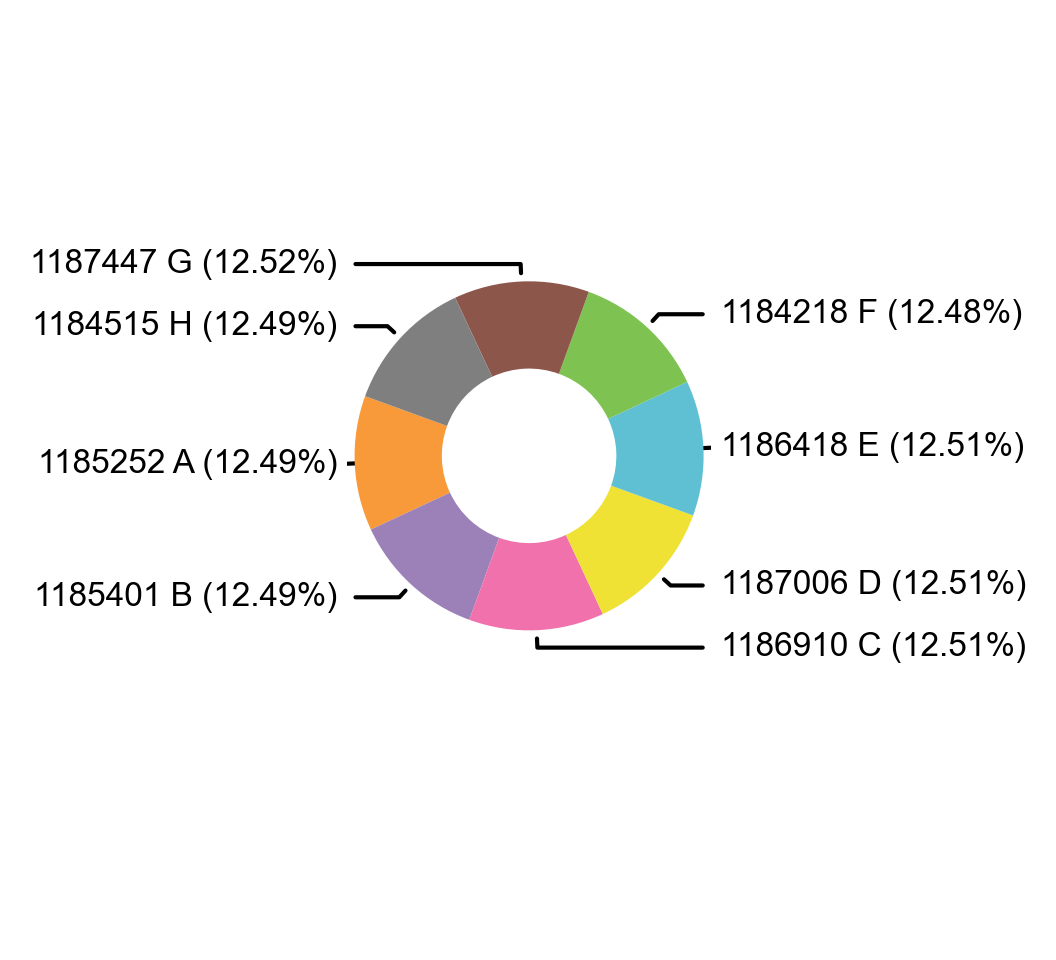

In [30]:
fig, ax = pyplot.subplots(1, 1, figsize=(3.25,3))
i=0

dict_all_cells_true = all_cells_c_m.sort_index()['observed'].to_dict()
cells = np.array([k for k, v in dict_all_cells_true.items()])
cell_counts = np.array([v for k, v in dict_all_cells_true.items()])
norm_cell_counts = np.round(cell_counts/cell_counts.sum()*100, 2)

norm_cell_counts_str = [f' ('+str(percent)+'%)' for ind, percent in enumerate(norm_cell_counts)]
annot = [str(count)+' '+cell+suffix for count, cell, suffix in zip(cell_counts, cells, norm_cell_counts_str)]

data = dict_all_cells_true.values()

colors_to_use = cell_color_dict.values()
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-200, colors=colors_to_use, )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for b, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(annot[b], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                horizontalalignment=horizontalalignment, **kw, **{'fontname':'Arial', 'size':8})

#ax.set_title(f"Pre-determined states \n cell fate proportions", y=1, **{'fontname':'DejaVu Sans', 'size':8})

pyplot.tight_layout(h_pad=-8, w_pad=4)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.grid(False)
#pyplot.title("Cell fate proportions across zebrafish retina regions", y=0, **{'fontname':'DejaVu Sans', 'size':8}, fontweight="bold")

image_format = 'svg'

pyplot.savefig(f"predet_states_model_cell_fate_proportions_v02_composite.{image_format}", dpi=300, bbox_inches="tight")

In [31]:
for i, j in enumerate(all_trees_sorted[990:]):
    print(i, j)

0 (((G,H),(H,H)),((F,(F,F)),(E,(F,F))))
1 (((((E,F),(F,F)),(H,(G,G))),((A,A),(B,(A,B)))),(((E,E),(E,F)),(F,(E,F))))
2 ((((((B,B),((C,(C,D)),(A,B))),((H,(G,G)),(F,(F,(E,E))))),((H,(H,H)),(H,H))),(((((G,(H,H)),(G,H)),(E,F)),(E,E)),((B,B),(B,B)))),((B,(A,A)),((A,(A,(A,(A,A)))),(B,B))))
3 (((G,H),(G,H)),((F,F),((G,H),(G,H))))
4 ((((A,B),(C,D)),((A,(A,B)),(B,B))),((E,F),(((E,E),((G,H),(F,(E,F)))),(F,F))))
5 (((E,F),(F,F)),((E,F),(G,H)))
6 (((((H,(G,G)),(E,(E,E))),((C,C),(C,D))),((B,(A,(B,B))),(C,D))),((B,B),(C,(C,D))))
7 (((G,G),(E,(E,F))),((A,(A,B)),(D,(C,D))))
8 ((((F,F),(H,(G,H))),((G,(G,H)),(F,F))),((E,E),((G,(H,H)),(H,(G,(H,(G,(H,(G,(G,G))))))))))
9 (((E,E),((F,F),(H,H))),((A,A),(C,C)))
10 (((H,(G,(G,H))),(E,F)),(((C,C),((A,A),(D,D))),(C,D)))
11 (((C,(C,C)),(C,D)),((F,(E,F)),(G,G)))
12 (((A,B),((A,B),(B,B))),((E,(E,(F,(F,(F,(F,F)))))),(G,G)))
13 (((F,F),(((E,F),(F,(E,F))),(E,E))),(((A,A),(C,D)),((B,B),(C,D))))
14 ((((((F,(F,F)),(F,F)),(E,(E,F))),(G,H)),((F,(E,(F,F))),(E,(E,F)))),((G,H)

In [32]:
cell_color_dict_for_trees = make_color_dict(cell_fates, ['#df8a34', '#8c73a5', '#d86599', '#d8ca2f','#55acbe', '#71af49',]+[colorcet.glasbey_category10[5]]+[colorcet.glasbey_category10[7]])

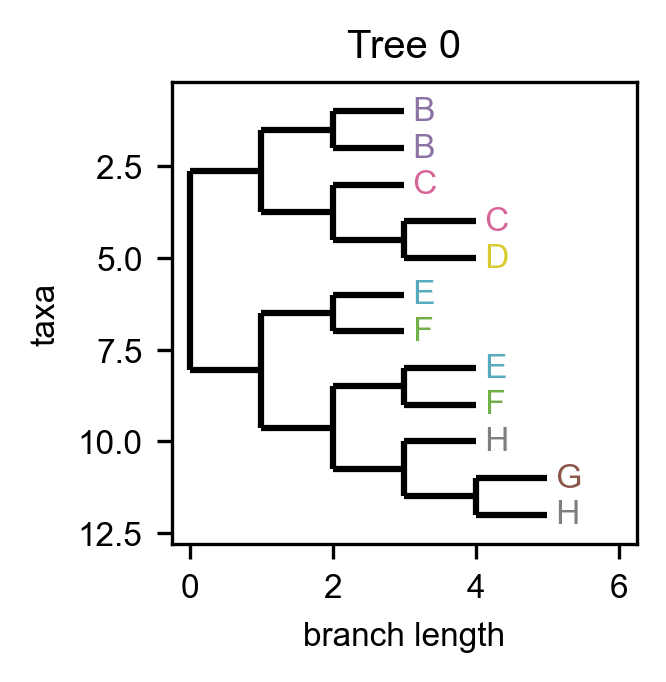

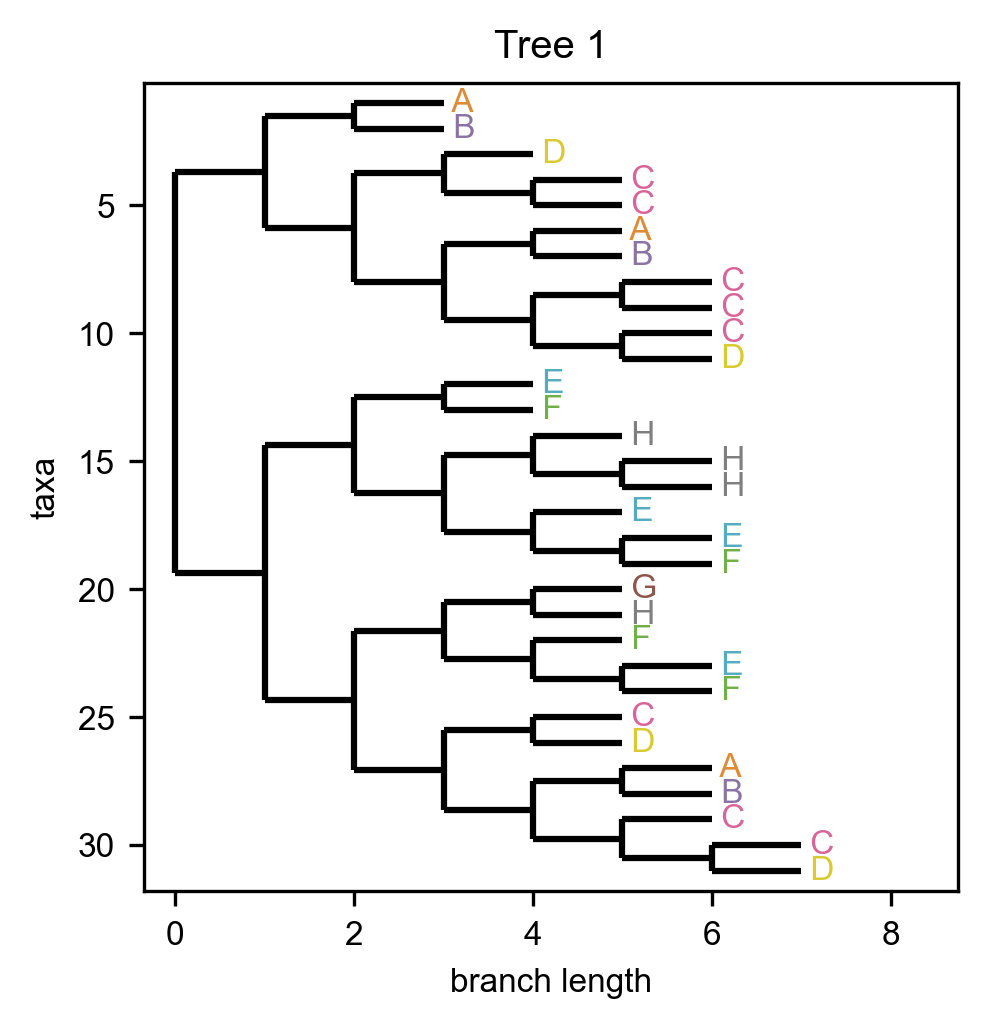

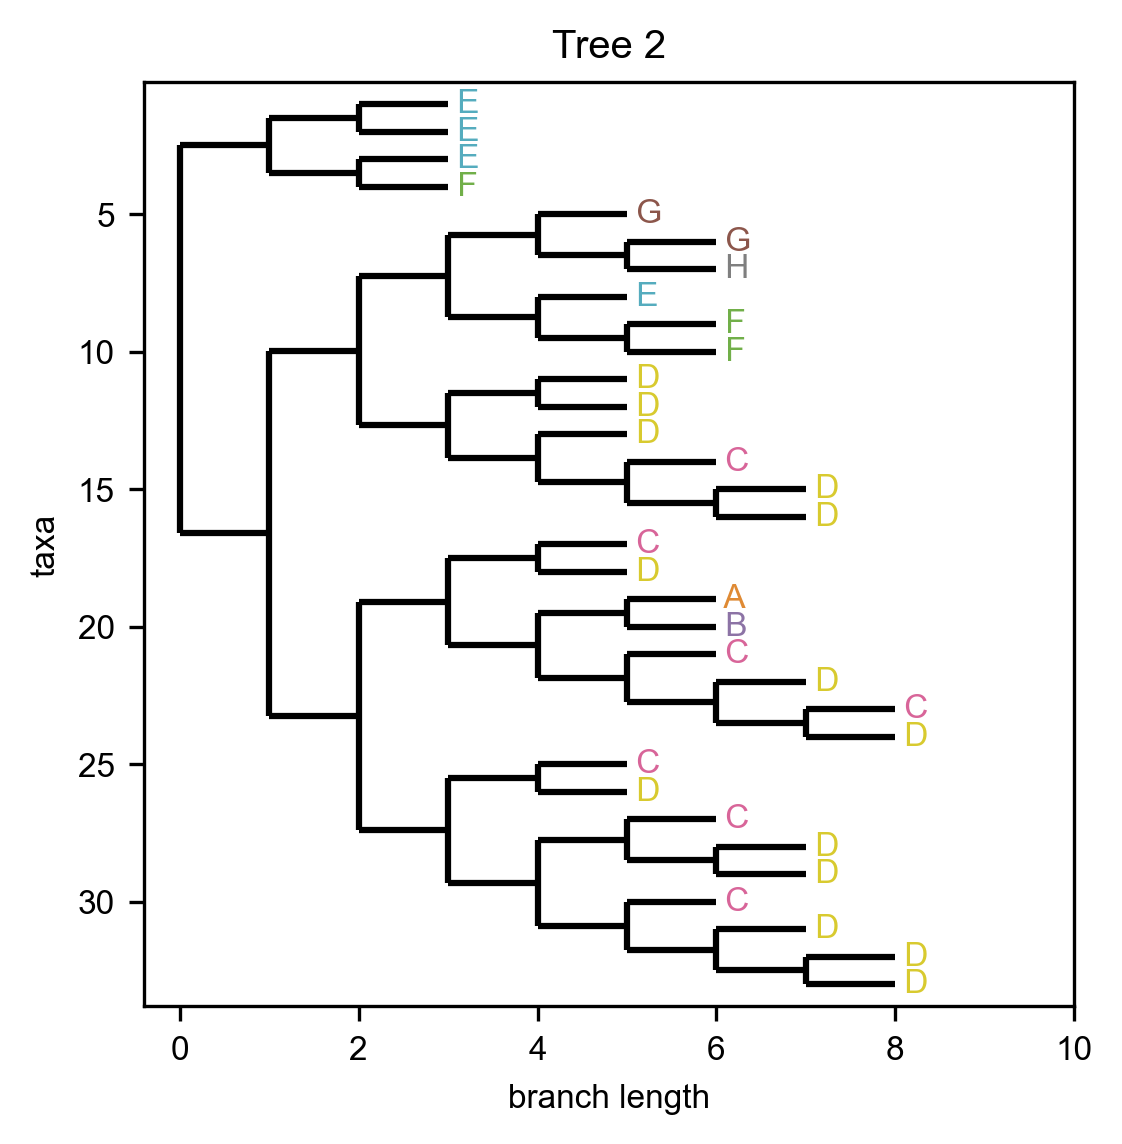

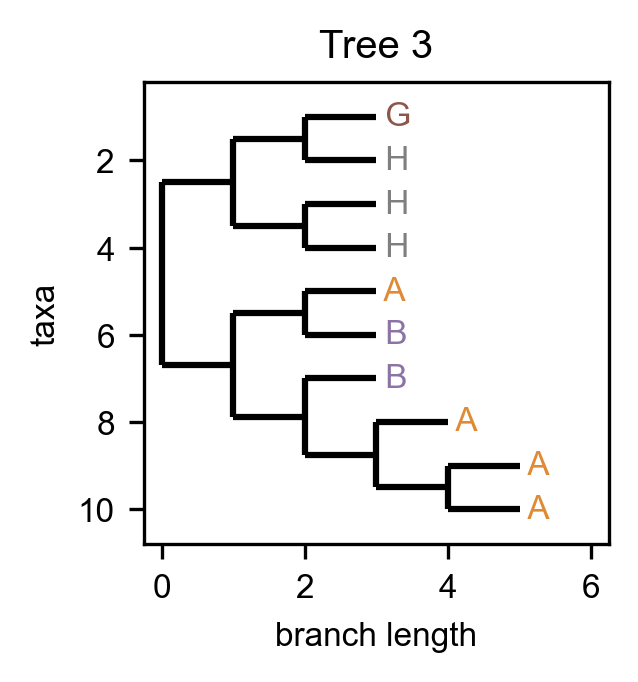

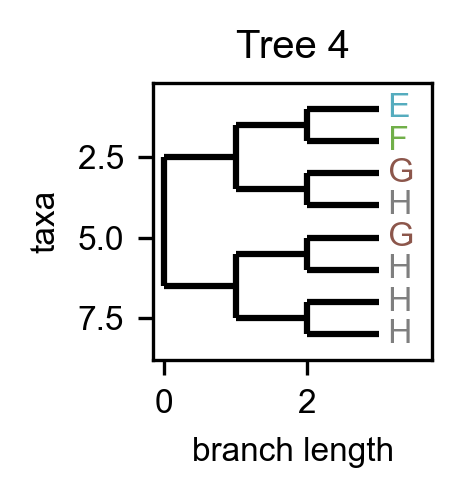

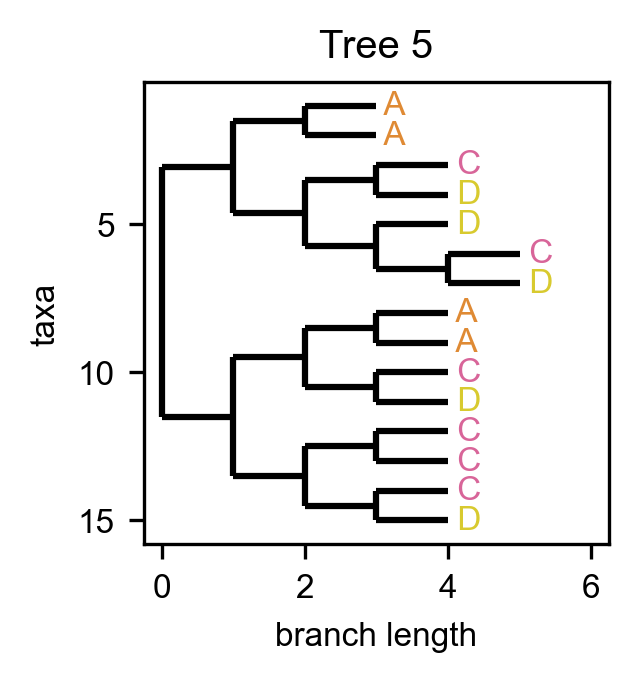

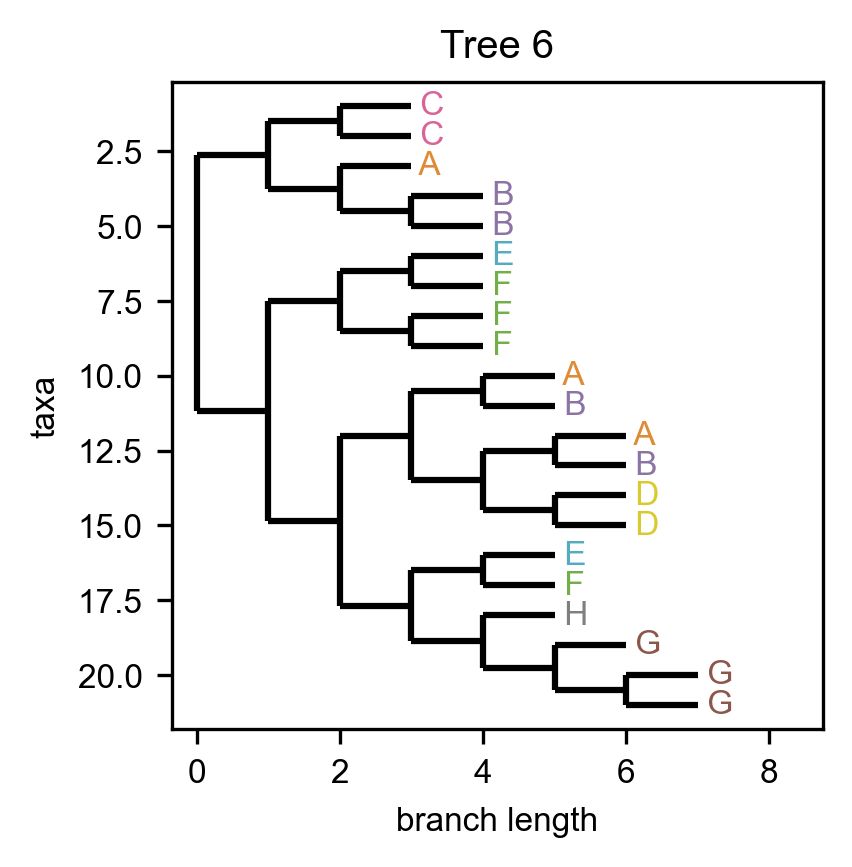

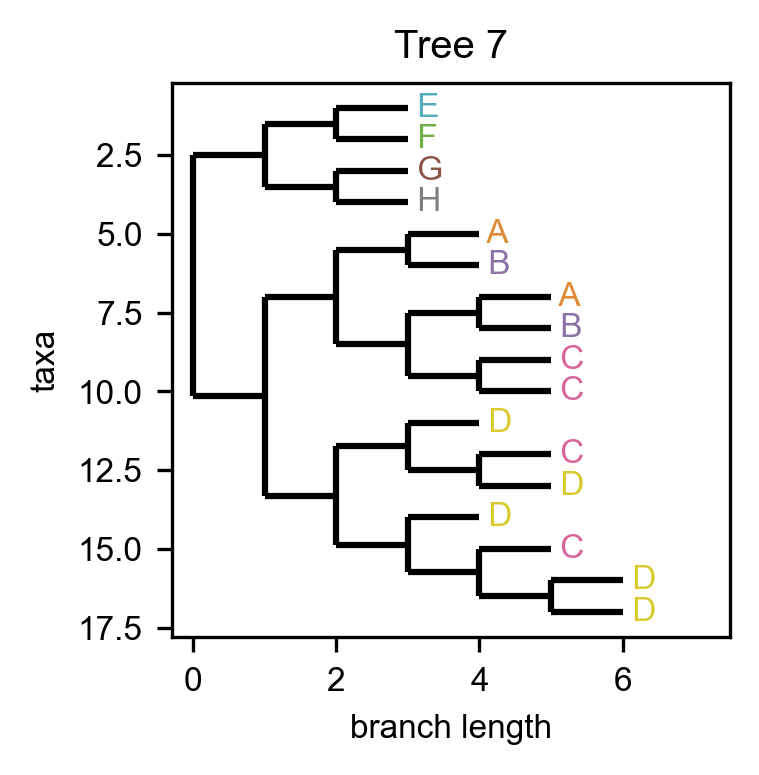

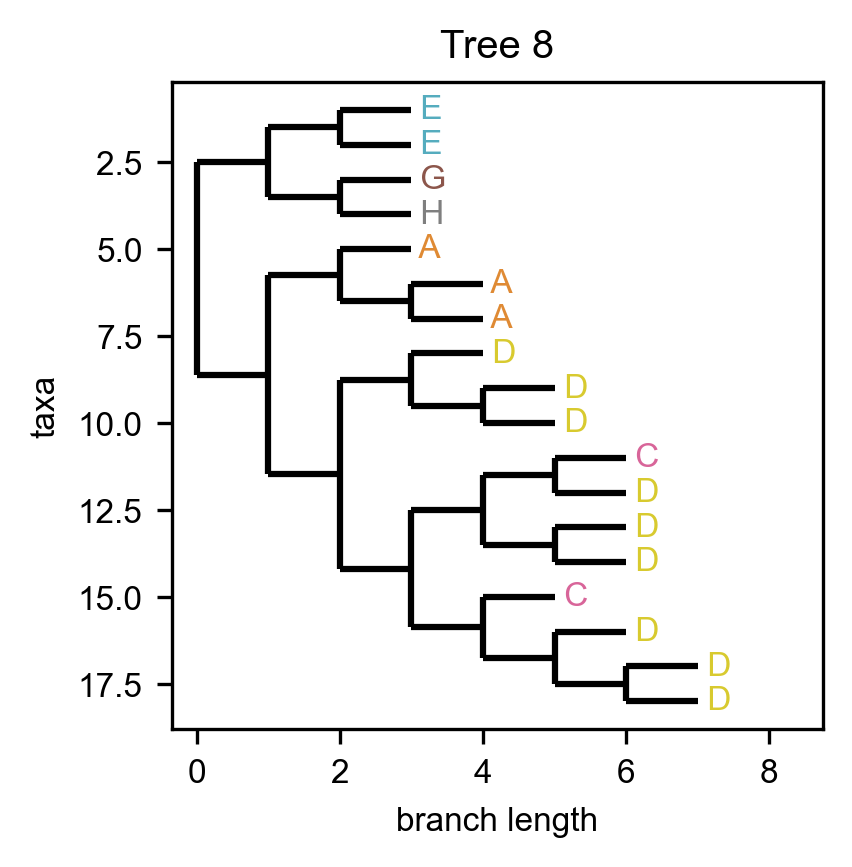

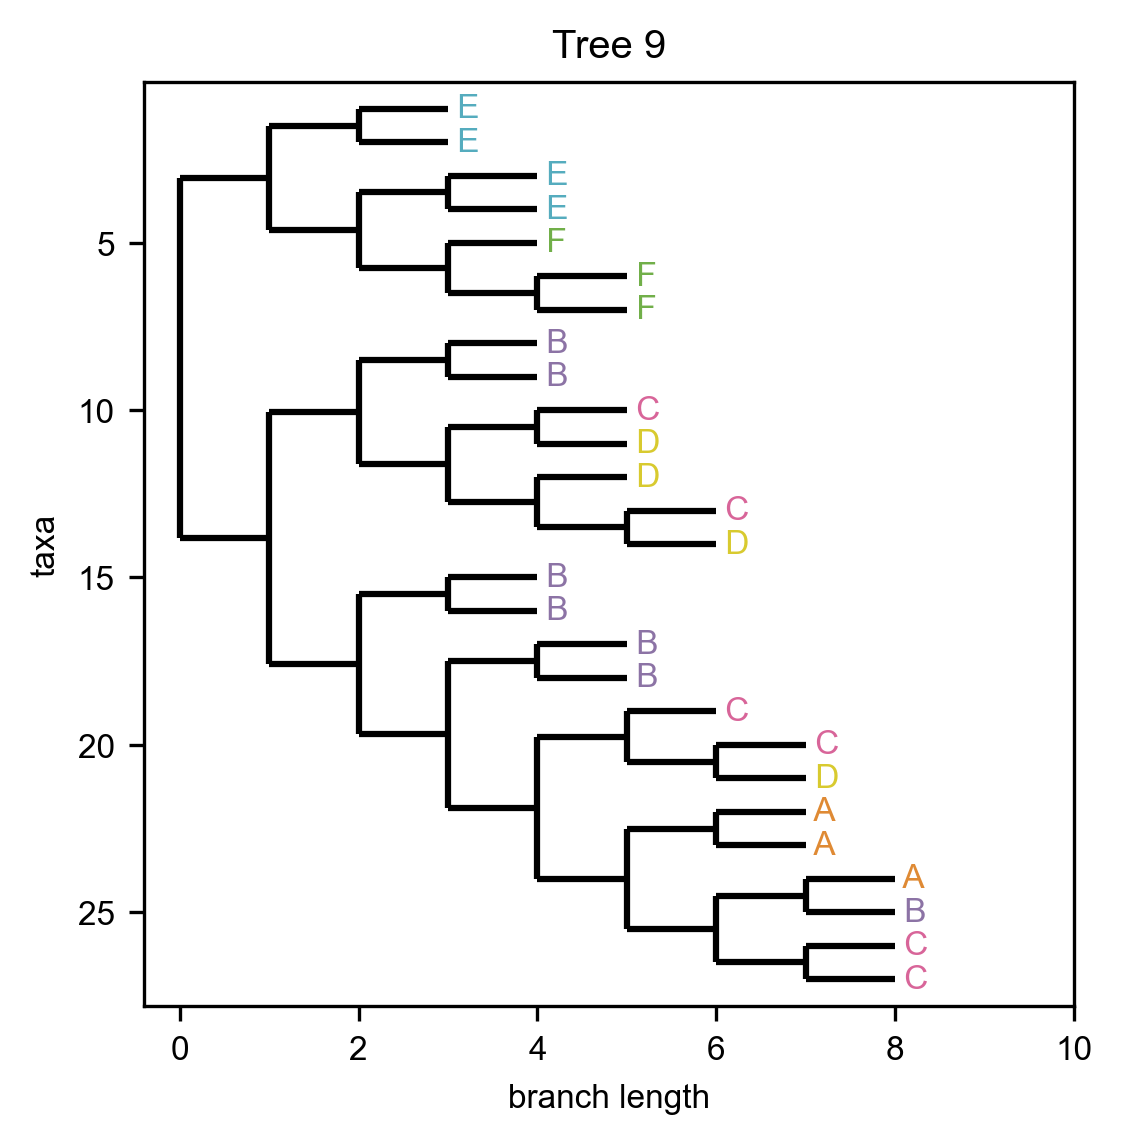

In [12]:
for i, ind in enumerate(range(10)):
    tree = Phylo.read(io.StringIO(all_trees_sorted[ind]), "newick")
    tree.ladderize()
    depth = max(TreeMixin.depths(tree, unit_branch_lengths=True).values())
    num_cells = len(re.findall("[A-Za-z0-9]+", all_trees_sorted[ind]))
    size = depth*0.4
    if size < 1:
        size = 1
    if num_cells > 25:
        size *= 1.25

    fig, ax = pyplot.subplots(1, 1, figsize=(size,size))
    #pyplot.grid(None)

    Phylo.draw(tree,
            axes=ax,
            label_colors=cell_color_dict_for_trees,
            do_show=False
    )

    pyplot.title(f'Tree {i}')
    #pyplot.axis('off')
    pyplot.savefig(f"predet_states_model_v02_tree_{i}.svg", bbox_inches="tight")

In [369]:
subtree_list = ['doublet',
                'quartet',
                'octet'
                ]

num_trees_list = [50000]

df_true_melt_subset_list = []
df_null_zscores_i_c_melt_subset_list = []

for subtree in subtree_list:
    for num_trees in num_trees_list:
        for rep in range(10):
            df_true_melt_subset = pd.read_csv(f'../data/predet_states_model_v02_2/df_true_melt_subset_{subtree}_trees{num_trees}_rep{rep}.csv', index_col=0)
            df_true_melt_subset['rep'] = rep
            df_true_melt_subset['subtree'] = subtree
            df_true_melt_subset_list.append(df_true_melt_subset)

            df_null_zscores_i_c_melt_subset = pd.read_csv(f'../data/predet_states_model_v02_2/df_null_zscores_i_c_melt_subset_{subtree}_trees{num_trees}_rep{rep}.csv', index_col=0)
            df_null_zscores_i_c_melt_subset['rep'] = rep
            df_null_zscores_i_c_melt_subset['subtree'] = subtree
            df_null_zscores_i_c_melt_subset_list.append(df_null_zscores_i_c_melt_subset)

In [370]:
df_true_melt_subset_c = pd.concat(df_true_melt_subset_list)
df_true_melt_subset_c

subtree_val  observed     z-score  abs z-score  \
34             34   47708.0  333.939753   333.939753   
16             16   47274.0  329.099368   329.099368   
27             27   48129.0  327.948888   327.948888   
1               1   47242.0  320.453236   320.453236   
33             33   23838.0  236.469898   236.469898   
...           ...       ...         ...          ...   
507           507      11.0   -0.419612     0.419612   
579           579      11.0   -0.714949     0.714949   
567           567      10.0   -0.851852     0.851852   
9135         9135      10.0   -0.905722     0.905722   
102           102      10.0   -0.919535     0.919535   

                              label  null min  null mean  null max     p_val  \
34                            (G,H)   11580.0  11953.402   12260.0  0.000999   
16                            (C,D)   11403.0  11798.396   12193.0  0.000999   
27                            (E,F)   11600.0  12040.919   12408.0  0.000999   
1                             (A,B)   11447.0  11780.360   12078.0  0.000999   
33                            (G,G)    5760.0   5988.534    6249.0  0.000999   
...                             ...       ...        ...       ...       ...   
507   (((A,B),(C,C)),((E,F),(G,H)))       3.0     12.464      25.0  0.411000   
579   (((A,B),(C,D)),((F,F),(G,H)))       4.0     13.714      28.0  0.299000   
567   (((A,B),(C,D)),((E,F),(H,H)))       4.0     12.898      25.0  0.241000   
9135  (((B,B),(C,D)),((E,F),(G,H)))       4.0     13.358      26.0  0.230000   
102   (((A,A),(C,D)),((E,F),(G,H)))       4.0     13.234      28.0  0.220000   

      adj_p_val_fdr_bh  adj_p_val_fdr_tsbh  null z-score min  \
34            0.000999            0.000999         -1.952083   
16            0.000999            0.000999         -2.875557   
27            0.000999            0.000999         -2.646444   
1             0.000999            0.000999         -2.672113   
33            0.000999            0.000999         -2.990912   
...                ...                 ...               ...   
507           1.000000            1.000000          0.153707   
579           1.000000            1.000000         -1.243390   
567           1.000000            1.000000         -0.264104   
9135          1.000000            1.000000         -0.096609   
102           1.000000            1.000000         -0.920385   

      null z-score mean  null z-score max  rep  subtree  
34            -0.113639          2.689092    0  doublet  
16            -0.100192          2.567716    0  doublet  
27            -0.138143          2.381680    0  doublet  
1             -0.033875          2.428139    0  doublet  
33            -0.089532          1.999312    0  doublet  
...                 ...               ...  ...      ...  
507            0.153707          0.153707    9    octet  
579           -1.243390         -1.243390    9    octet  
567           -0.264104         -0.264104    9    octet  
9135          -0.096609         -0.096609    9    octet  
102           -0.920385         -0.920385    9    octet  

[1560 rows x 16 columns]

In [371]:
cutoff=17
subtree = 'doublet'

df_true_melt_subset_c_subtree = df_true_melt_subset_c.loc[df_true_melt_subset_c['subtree']==subtree]
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree_m.sort_values('abs z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m.loc[df_true_melt_subset_c_subtree_m['subtree_val'].isin(subtree_vals_to_use)]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m_ss.sort_values('z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_63831/761381489.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()


label  subtree_val  observed     z-score  abs z-score  null min  \
34  (G,H)         34.0   47437.4  336.648739   336.648739   11506.4   
1   (A,B)          1.0   47385.1  331.906265   331.906265   11502.4   
16  (C,D)         16.0   47496.5  331.455408   331.455408   11522.5   
27  (E,F)         27.0   47422.1  329.723582   329.723582   11490.4   
8   (B,B)          8.0   23731.2  234.050662   234.050662    5680.0   
33  (G,G)         33.0   23753.5  233.981325   233.981325    5694.3   
26  (E,E)         26.0   23744.1  233.976985   233.976985    5689.9   
0   (A,A)          0.0   23736.9  233.270988   233.270988    5665.0   
21  (D,D)         21.0   23686.6  231.530758   231.530758    5701.8   
15  (C,C)         15.0   23739.2  231.346826   231.346826    5676.3   
30  (F,F)         30.0   23645.2  230.599207   230.599207    5656.5   
35  (H,H)         35.0   23620.1  228.795156   228.795156    5663.3   
28  (E,G)         28.0       0.0 -111.372575   111.372575   11530.0   
4   (A,E)          4.0       0.0 -111.501033   111.501033   11514.8   
10  (B,D)         10.0       0.0 -111.571585   111.571585   11518.1   
25  (D,H)         25.0       0.0 -111.997695   111.997695   11527.2   
9   (B,C)          9.0       0.0 -112.023924   112.023924   11510.9   

     null mean  null max     p_val  adj_p_val_fdr_bh  adj_p_val_fdr_tsbh  \
34  11858.0701   12190.9  0.000999          0.000999            0.000999   
1   11846.1308   12194.4  0.000999          0.000999            0.000999   
16  11878.2170   12227.8  0.000999          0.000999            0.000999   
27  11845.3225   12215.2  0.000999          0.000999            0.000999   
8    5922.2206    6162.9  0.000999          0.000999            0.000999   
33   5941.7417    6201.6  0.000999          0.000999            0.000999   
26   5934.4026    6181.4  0.000999          0.000999            0.000999   
0    5921.9755    6165.3  0.000999          0.000999            0.000999   
21   5940.2169    6196.5  0.000999          0.000999            0.000999   
15   5938.0381    6185.3  0.000999          0.000999            0.000999   
30   5912.9649    6160.8  0.000999          0.000999            0.000999   
35   5915.3422    6173.1  0.000999          0.000999            0.000999   
28  11876.8908   12225.4  0.000999          0.000999            0.000999   
4   11854.3857   12207.5  0.000999          0.000999            0.000999   
10  11861.6844   12211.8  0.000999          0.000999            0.000999   
25  11852.5094   12199.4  0.000999          0.000999            0.000999   
9   11861.0252   12205.4  0.000999          0.000999            0.000999   

    null z-score min  null z-score mean  null z-score max  rep  
34         -2.409029           0.018431          2.540788  4.5  
1          -2.576809          -0.040675          2.582443  4.5  
16         -2.397126           0.012318          2.693303  4.5  
27         -2.592873          -0.019030          2.488081  4.5  
8          -2.615026          -0.032900          2.454555  4.5  
33         -2.820910          -0.010093          2.329837  4.5  
26         -2.434335           0.049439          2.558433  4.5  
0          -2.555740          -0.003672          2.715981  4.5  
21         -2.511852          -0.005572          2.470785  4.5  
15         -2.596118          -0.002836          2.596654  4.5  
30         -2.657505          -0.041089          2.762611  4.5  
35         -2.388793           0.066982          2.387020  4.5  
28         -2.359927          -0.000065          2.585090  4.5  
4          -2.404590           0.040715          2.497544  4.5  
10         -2.689569          -0.024622          2.696267  4.5  
25         -2.574345           0.008625          2.707421  4.5  
9          -2.515046           0.001063          2.515707  4.5

In [372]:
df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()
std_list = [df_true_melt_subset_c_subtree_std.loc[df_true_melt_subset_c_subtree_std['label']==i]['z-score'].values[0] for i in df_true_melt_subset_c_subtree_m_ss['label']]
df_true_melt_subset_c_subtree_m_ss['std'] = std_list
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_63831/3231623101.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()


label  subtree_val  observed     z-score  abs z-score  null min  \
34  (G,H)         34.0   47437.4  336.648739   336.648739   11506.4   
1   (A,B)          1.0   47385.1  331.906265   331.906265   11502.4   
16  (C,D)         16.0   47496.5  331.455408   331.455408   11522.5   
27  (E,F)         27.0   47422.1  329.723582   329.723582   11490.4   
8   (B,B)          8.0   23731.2  234.050662   234.050662    5680.0   
33  (G,G)         33.0   23753.5  233.981325   233.981325    5694.3   
26  (E,E)         26.0   23744.1  233.976985   233.976985    5689.9   
0   (A,A)          0.0   23736.9  233.270988   233.270988    5665.0   
21  (D,D)         21.0   23686.6  231.530758   231.530758    5701.8   
15  (C,C)         15.0   23739.2  231.346826   231.346826    5676.3   
30  (F,F)         30.0   23645.2  230.599207   230.599207    5656.5   
35  (H,H)         35.0   23620.1  228.795156   228.795156    5663.3   
28  (E,G)         28.0       0.0 -111.372575   111.372575   11530.0   
4   (A,E)          4.0       0.0 -111.501033   111.501033   11514.8   
10  (B,D)         10.0       0.0 -111.571585   111.571585   11518.1   
25  (D,H)         25.0       0.0 -111.997695   111.997695   11527.2   
9   (B,C)          9.0       0.0 -112.023924   112.023924   11510.9   

     null mean  null max     p_val  adj_p_val_fdr_bh  adj_p_val_fdr_tsbh  \
34  11858.0701   12190.9  0.000999          0.000999            0.000999   
1   11846.1308   12194.4  0.000999          0.000999            0.000999   
16  11878.2170   12227.8  0.000999          0.000999            0.000999   
27  11845.3225   12215.2  0.000999          0.000999            0.000999   
8    5922.2206    6162.9  0.000999          0.000999            0.000999   
33   5941.7417    6201.6  0.000999          0.000999            0.000999   
26   5934.4026    6181.4  0.000999          0.000999            0.000999   
0    5921.9755    6165.3  0.000999          0.000999            0.000999   
21   5940.2169    6196.5  0.000999          0.000999            0.000999   
15   5938.0381    6185.3  0.000999          0.000999            0.000999   
30   5912.9649    6160.8  0.000999          0.000999            0.000999   
35   5915.3422    6173.1  0.000999          0.000999            0.000999   
28  11876.8908   12225.4  0.000999          0.000999            0.000999   
4   11854.3857   12207.5  0.000999          0.000999            0.000999   
10  11861.6844   12211.8  0.000999          0.000999            0.000999   
25  11852.5094   12199.4  0.000999          0.000999            0.000999   
9   11861.0252   12205.4  0.000999          0.000999            0.000999   

    null z-score min  null z-score mean  null z-score max  rep       std  
34         -2.409029           0.018431          2.540788  4.5  6.306937  
1          -2.576809          -0.040675          2.582443  4.5  8.079480  
16         -2.397126           0.012318          2.693303  4.5  7.721299  
27         -2.592873          -0.019030          2.488081  4.5  6.788359  
8          -2.615026          -0.032900          2.454555  4.5  5.335929  
33         -2.820910          -0.010093          2.329837  4.5  5.144138  
26         -2.434335           0.049439          2.558433  4.5  4.413675  
0          -2.555740          -0.003672          2.715981  4.5  6.013107  
21         -2.511852          -0.005572          2.470785  4.5  5.702349  
15         -2.596118          -0.002836          2.596654  4.5  5.358164  
30         -2.657505          -0.041089          2.762611  4.5  4.969774  
35         -2.388793           0.066982          2.387020  4.5  8.526716  
28         -2.359927          -0.000065          2.585090  4.5  2.914388  
4          -2.404590           0.040715          2.497544  4.5  1.564653  
10         -2.689569          -0.024622          2.696267  4.5  2.276327  
25         -2.574345           0.008625          2.707421  4.5  2.129624  
9          -2.515046           0.001063          2.515707  4.5  2.153038

In [373]:
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
subtree_vals_to_use

array([34.,  1., 16., 27.,  8., 33., 26.,  0., 21., 15., 30., 35., 28.,
        4., 10., 25.,  9.])

In [374]:
df_null_zscores_i_c_melt_subset_c = pd.concat(df_null_zscores_i_c_melt_subset_list)
df_null_zscores_i_c_melt_subset_c_subtree = df_null_zscores_i_c_melt_subset_c.loc[df_null_zscores_i_c_melt_subset_c['subtree']==subtree]

df_null_zscores_i_c_melt_subset_c_subtree_ss = pd.concat([df_null_zscores_i_c_melt_subset_c_subtree.loc[df_null_zscores_i_c_melt_subset_c_subtree['subtree_val']==subtree_val_to_use] for subtree_val_to_use in subtree_vals_to_use])
df_null_zscores_i_c_melt_subset_c_subtree_ss

subtree_val  observed  label  rep  subtree
3400           34  0.678878  (G,H)    0  doublet
3401           34  0.501151  (G,H)    0  doublet
3402           34  1.081364  (G,H)    0  doublet
3403           34  0.052331  (G,H)    0  doublet
3404           34  0.706945  (G,H)    0  doublet
...           ...       ...    ...  ...      ...
995             9 -0.530751  (B,C)    9  doublet
996             9  1.497618  (B,C)    9  doublet
997             9  1.962405  (B,C)    9  doublet
998             9 -1.012400  (B,C)    9  doublet
999             9 -0.743723  (B,C)    9  doublet

[17000 rows x 5 columns]

In [375]:
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0 = df_null_zscores_i_c_melt_subset_c_subtree_ss.loc[df_null_zscores_i_c_melt_subset_c_subtree_ss['rep']==0]
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0

subtree_val  observed  label  rep  subtree
3400           34  0.678878  (G,H)    0  doublet
3401           34  0.501151  (G,H)    0  doublet
3402           34  1.081364  (G,H)    0  doublet
3403           34  0.052331  (G,H)    0  doublet
3404           34  0.706945  (G,H)    0  doublet
...           ...       ...    ...  ...      ...
995             9 -0.589398  (B,C)    0  doublet
996             9 -1.373438  (B,C)    0  doublet
997             9  0.382219  (B,C)    0  doublet
998             9 -0.693214  (B,C)    0  doublet
999             9 -0.825375  (B,C)    0  doublet

[1700 rows x 5 columns]

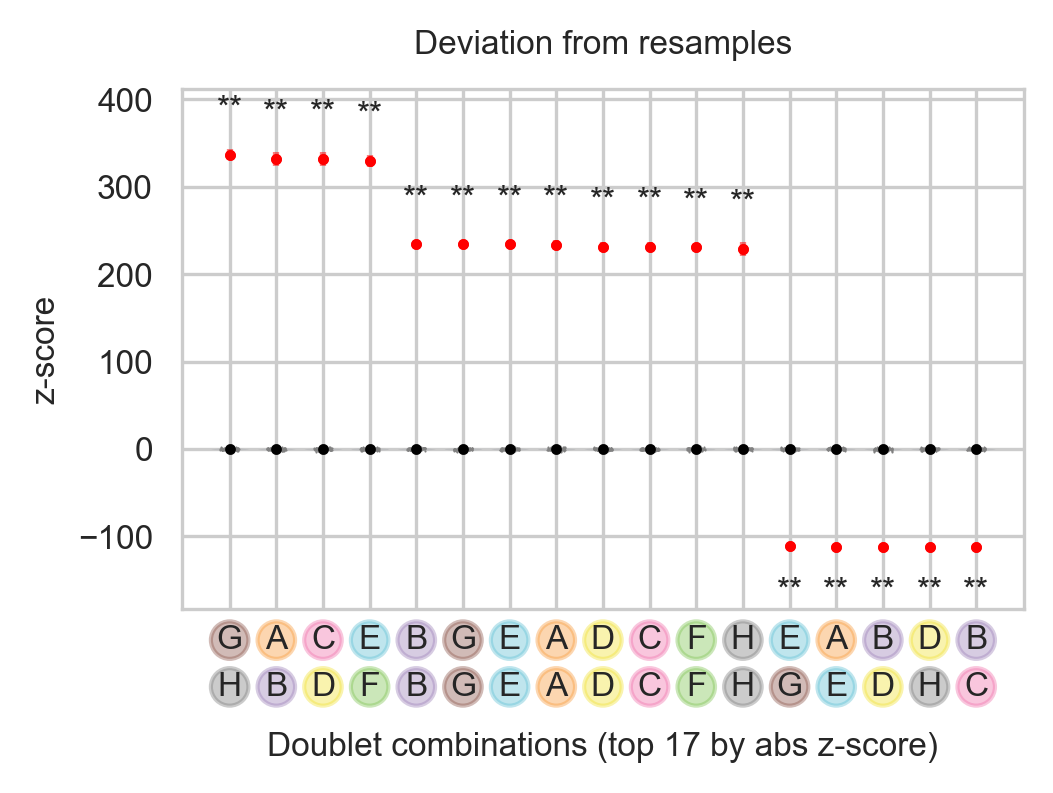

In [381]:
plot_deviation('doublet', 
               df_true_melt_subset_c_subtree_m_ss, 
               df_null_zscores_i_c_melt_subset_c_subtree_ss,
               df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0,
               cell_color_dict,
               legend_bool=False,
               save=True, 
                   image_format='svg',
                   dpi=300,
                   image_save_path='predet_states_model_v02_doublets')

In [382]:
cutoff=17
subtree = 'quartet'

df_true_melt_subset_c_subtree = df_true_melt_subset_c.loc[df_true_melt_subset_c['subtree']==subtree]
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree_m.sort_values('abs z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m.loc[df_true_melt_subset_c_subtree_m['subtree_val'].isin(subtree_vals_to_use)]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m_ss.sort_values('z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_63831/1183797713.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()


label  subtree_val  observed    z-score  abs z-score  null min  \
4   ((A,B),(C,D))         34.0    3628.7  33.156005    33.156005    1978.1   
73  ((E,F),(G,H))        527.0    3604.7  32.726430    32.726430    1981.2   
50  ((C,C),(G,H))        390.0       0.0 -32.750563    32.750563     956.2   
1   ((A,A),(E,F))         15.0       0.0 -32.780455    32.780455     956.9   
2   ((A,A),(G,H))         20.0       0.0 -32.789961    32.789961     948.5   
13  ((B,B),(E,F))        240.0       0.0 -32.838128    32.838128     962.0   
14  ((B,B),(G,H))        245.0       0.0 -32.856875    32.856875     964.5   
11  ((A,B),(H,H))         53.0       0.0 -32.902272    32.902272     953.1   
70  ((D,D),(G,H))        476.0       0.0 -32.927029    32.927029     962.7   
66  ((C,D),(G,G))        406.0       0.0 -32.992836    32.992836     957.8   
45  ((C,C),(E,F))        385.0       0.0 -33.029588    33.029588     956.2   
9   ((A,B),(G,G))         51.0       0.0 -33.091932    33.091932     957.6   
63  ((C,D),(F,F))        403.0       0.0 -33.183910    33.183910     959.8   
7   ((A,B),(E,F))         45.0       0.0 -46.632695    46.632695    1966.8   
67  ((C,D),(G,H))        407.0       0.0 -46.766504    46.766504    1966.3   
60  ((C,D),(E,F))        400.0       0.0 -46.868640    46.868640    1971.4   
10  ((A,B),(G,H))         52.0       0.0 -47.128589    47.128589    1978.6   

    null mean  null max  p_val  adj_p_val_fdr_bh  adj_p_val_fdr_tsbh  \
4   2123.4085    2274.6    0.0               0.0                 0.0   
73  2122.7063    2275.5    0.0               0.0                 0.0   
50  1061.8124    1161.7    0.0               0.0                 0.0   
1   1062.4750    1170.8    0.0               0.0                 0.0   
2   1062.3591    1167.1    0.0               0.0                 0.0   
13  1061.4057    1172.7    0.0               0.0                 0.0   
14  1061.7797    1165.5    0.0               0.0                 0.0   
11  1055.6439    1161.1    0.0               0.0                 0.0   
70  1059.9072    1161.3    0.0               0.0                 0.0   
66  1064.2627    1171.5    0.0               0.0                 0.0   
45  1062.1917    1164.4    0.0               0.0                 0.0   
9   1061.9648    1169.7    0.0               0.0                 0.0   
63  1059.6599    1171.5    0.0               0.0                 0.0   
7   2119.8822    2278.3    0.0               0.0                 0.0   
67  2126.5479    2266.7    0.0               0.0                 0.0   
60  2124.7326    2268.1    0.0               0.0                 0.0   
10  2120.8406    2275.9    0.0               0.0                 0.0   

    null z-score min  null z-score mean  null z-score max  rep  
4          -2.644461          -0.045255          2.578677  4.5  
73         -2.390081           0.015257          2.705078  4.5  
50         -2.247005           0.004348          2.374436  4.5  
1          -2.506434          -0.025457          2.524140  4.5  
2          -2.367638          -0.035707          2.207344  4.5  
13         -2.423636          -0.004651          2.434810  4.5  
14         -2.327056           0.026274          2.619896  4.5  
11         -2.565958           0.018089          2.638753  4.5  
70         -2.618983          -0.032464          2.634771  4.5  
66         -2.468990          -0.003464          2.741969  4.5  
45         -2.596136          -0.017040          2.438552  4.5  
9          -2.562843           0.014319          2.406541  4.5  
63         -2.377619          -0.011003          2.692158  4.5  
7          -2.374846           0.026780          3.148647  4.5  
67         -2.730308          -0.033580          2.498495  4.5  
60         -2.449528           0.043950          2.444586  4.5  
10         -2.594506           0.008857          2.908841  4.5

In [383]:
df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()
std_list = [df_true_melt_subset_c_subtree_std.loc[df_true_melt_subset_c_subtree_std['label']==i]['z-score'].values[0] for i in df_true_melt_subset_c_subtree_m_ss['label']]
df_true_melt_subset_c_subtree_m_ss['std'] = std_list
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_63831/3231623101.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()


label  subtree_val  observed    z-score  abs z-score  null min  \
4   ((A,B),(C,D))         34.0    3628.7  33.156005    33.156005    1978.1   
73  ((E,F),(G,H))        527.0    3604.7  32.726430    32.726430    1981.2   
50  ((C,C),(G,H))        390.0       0.0 -32.750563    32.750563     956.2   
1   ((A,A),(E,F))         15.0       0.0 -32.780455    32.780455     956.9   
2   ((A,A),(G,H))         20.0       0.0 -32.789961    32.789961     948.5   
13  ((B,B),(E,F))        240.0       0.0 -32.838128    32.838128     962.0   
14  ((B,B),(G,H))        245.0       0.0 -32.856875    32.856875     964.5   
11  ((A,B),(H,H))         53.0       0.0 -32.902272    32.902272     953.1   
70  ((D,D),(G,H))        476.0       0.0 -32.927029    32.927029     962.7   
66  ((C,D),(G,G))        406.0       0.0 -32.992836    32.992836     957.8   
45  ((C,C),(E,F))        385.0       0.0 -33.029588    33.029588     956.2   
9   ((A,B),(G,G))         51.0       0.0 -33.091932    33.091932     957.6   
63  ((C,D),(F,F))        403.0       0.0 -33.183910    33.183910     959.8   
7   ((A,B),(E,F))         45.0       0.0 -46.632695    46.632695    1966.8   
67  ((C,D),(G,H))        407.0       0.0 -46.766504    46.766504    1966.3   
60  ((C,D),(E,F))        400.0       0.0 -46.868640    46.868640    1971.4   
10  ((A,B),(G,H))         52.0       0.0 -47.128589    47.128589    1978.6   

    null mean  null max  p_val  adj_p_val_fdr_bh  adj_p_val_fdr_tsbh  \
4   2123.4085    2274.6    0.0               0.0                 0.0   
73  2122.7063    2275.5    0.0               0.0                 0.0   
50  1061.8124    1161.7    0.0               0.0                 0.0   
1   1062.4750    1170.8    0.0               0.0                 0.0   
2   1062.3591    1167.1    0.0               0.0                 0.0   
13  1061.4057    1172.7    0.0               0.0                 0.0   
14  1061.7797    1165.5    0.0               0.0                 0.0   
11  1055.6439    1161.1    0.0               0.0                 0.0   
70  1059.9072    1161.3    0.0               0.0                 0.0   
66  1064.2627    1171.5    0.0               0.0                 0.0   
45  1062.1917    1164.4    0.0               0.0                 0.0   
9   1061.9648    1169.7    0.0               0.0                 0.0   
63  1059.6599    1171.5    0.0               0.0                 0.0   
7   2119.8822    2278.3    0.0               0.0                 0.0   
67  2126.5479    2266.7    0.0               0.0                 0.0   
60  2124.7326    2268.1    0.0               0.0                 0.0   
10  2120.8406    2275.9    0.0               0.0                 0.0   

    null z-score min  null z-score mean  null z-score max  rep       std  
4          -2.644461          -0.045255          2.578677  4.5  1.310439  
73         -2.390081           0.015257          2.705078  4.5  1.304261  
50         -2.247005           0.004348          2.374436  4.5  0.833337  
1          -2.506434          -0.025457          2.524140  4.5  0.608446  
2          -2.367638          -0.035707          2.207344  4.5  0.567590  
13         -2.423636          -0.004651          2.434810  4.5  0.726675  
14         -2.327056           0.026274          2.619896  4.5  0.651841  
11         -2.565958           0.018089          2.638753  4.5  0.664505  
70         -2.618983          -0.032464          2.634771  4.5  0.816344  
66         -2.468990          -0.003464          2.741969  4.5  0.874295  
45         -2.596136          -0.017040          2.438552  4.5  0.710189  
9          -2.562843           0.014319          2.406541  4.5  0.825864  
63         -2.377619          -0.011003          2.692158  4.5  0.460593  
7          -2.374846           0.026780          3.148647  4.5  0.971950  
67         -2.730308          -0.033580          2.498495  4.5  1.201562  
60         -2.449528           0.043950          2.444586  4.5  0.979259  
10         -2.594506           0.00

In [384]:
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
subtree_vals_to_use

array([ 34., 527., 390.,  15.,  20., 240., 245.,  53., 476., 406., 385.,
        51., 403.,  45., 407., 400.,  52.])

In [385]:
df_null_zscores_i_c_melt_subset_c = pd.concat(df_null_zscores_i_c_melt_subset_list)
df_null_zscores_i_c_melt_subset_c_subtree = df_null_zscores_i_c_melt_subset_c.loc[df_null_zscores_i_c_melt_subset_c['subtree']==subtree]

df_null_zscores_i_c_melt_subset_c_subtree_ss = pd.concat([df_null_zscores_i_c_melt_subset_c_subtree.loc[df_null_zscores_i_c_melt_subset_c_subtree['subtree_val']==subtree_val_to_use] for subtree_val_to_use in subtree_vals_to_use])
df_null_zscores_i_c_melt_subset_c_subtree_ss

subtree_val  observed          label  rep  subtree
3400           34  1.891148  ((A,B),(C,D))    0  quartet
3401           34 -0.557501  ((A,B),(C,D))    0  quartet
3402           34 -1.024761  ((A,B),(C,D))    0  quartet
3403           34 -0.046147  ((A,B),(C,D))    0  quartet
3404           34 -0.068377  ((A,B),(C,D))    0  quartet
...           ...       ...            ...  ...      ...
5295           52  2.588450  ((A,B),(G,H))    9  quartet
5296           52  0.172312  ((A,B),(G,H))    9  quartet
5297           52  1.528317  ((A,B),(G,H))    9  quartet
5298           52 -0.343607  ((A,B),(G,H))    9  quartet
5299           52 -1.075059  ((A,B),(G,H))    9  quartet

[17000 rows x 5 columns]

In [386]:
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0 = df_null_zscores_i_c_melt_subset_c_subtree_ss.loc[df_null_zscores_i_c_melt_subset_c_subtree_ss['rep']==0]
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0

subtree_val  observed          label  rep  subtree
3400           34  1.891148  ((A,B),(C,D))    0  quartet
3401           34 -0.557501  ((A,B),(C,D))    0  quartet
3402           34 -1.024761  ((A,B),(C,D))    0  quartet
3403           34 -0.046147  ((A,B),(C,D))    0  quartet
3404           34 -0.068377  ((A,B),(C,D))    0  quartet
...           ...       ...            ...  ...      ...
5295           52  0.812083  ((A,B),(G,H))    0  quartet
5296           52  0.473179  ((A,B),(G,H))    0  quartet
5297           52 -0.407500  ((A,B),(G,H))    0  quartet
5298           52 -0.317165  ((A,B),(G,H))    0  quartet
5299           52  0.044120  ((A,B),(G,H))    0  quartet

[1700 rows x 5 columns]

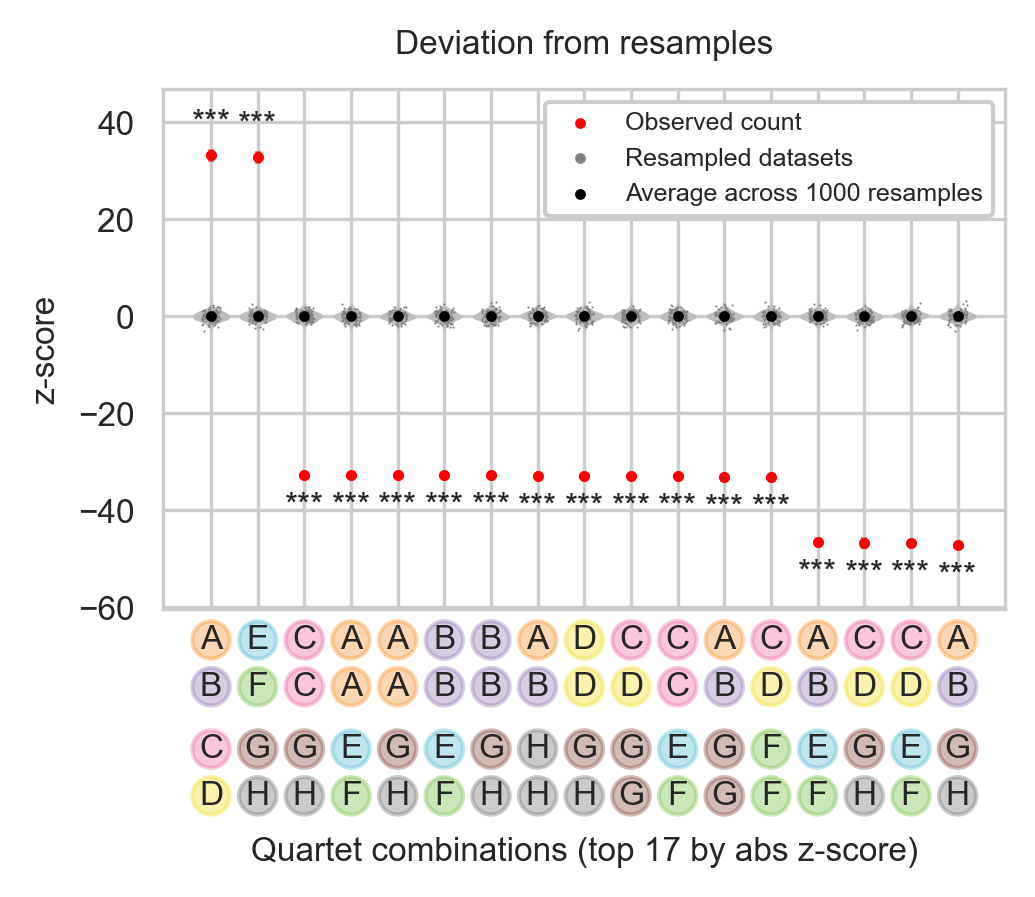

In [387]:
plot_deviation('quartet', 
               df_true_melt_subset_c_subtree_m_ss, 
               df_null_zscores_i_c_melt_subset_c_subtree_ss,
               df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0,
               cell_color_dict,
               legend_bool=True,
               legend_pos='inside',
               save=True, 
                   image_format='svg',
                   dpi=300,
                   image_save_path='predet_states_model_v02_quartet')

In [388]:
cutoff=17
subtree = 'octet'

df_true_melt_subset_c_subtree = df_true_melt_subset_c.loc[df_true_melt_subset_c['subtree']==subtree]
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree_m.sort_values('abs z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m.loc[df_true_melt_subset_c_subtree_m['subtree_val'].isin(subtree_vals_to_use)]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m_ss.sort_values('z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_63831/3719939868.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()


label  subtree_val  observed   z-score  \
5   (((A,B),(C,D)),((E,F),(G,H)))        566.0      32.2  1.239327   
59  (((B,B),(C,D)),((E,F),(G,H)))       9135.0      16.2  0.871043   
1   (((A,A),(C,D)),((E,F),(G,H)))        102.0      14.4  0.396008   
7   (((A,B),(C,D)),((F,F),(G,H)))        579.0      14.8  0.394661   
3   (((A,B),(C,D)),((E,E),(G,H)))        560.0      14.1  0.336468   
8   (((A,B),(D,D)),((E,F),(G,H)))        897.0      14.2  0.276185   
6   (((A,B),(C,D)),((E,F),(H,H)))        567.0      13.9  0.244729   
42  (((A,G),(B,D)),((B,F),(C,H)))       6946.0       0.0  0.000000   
39  (((A,G),(B,D)),((B,E),(C,H)))       6943.0       0.0  0.000000   
37  (((A,G),(B,D)),((B,C),(F,H)))       6941.0       0.0  0.000000   
41  (((A,G),(B,D)),((B,F),(C,E)))       6945.0       0.0  0.000000   
38  (((A,G),(B,D)),((B,E),(C,F)))       6942.0       0.0  0.000000   
43  (((A,G),(B,D)),((B,F),(E,H)))       6947.0       0.0  0.000000   
44  (((A,G),(B,D)),((C,E),(H,H)))       6967.0       0.0  0.000000   
40  (((A,G),(B,D)),((B,E),(F,H)))       6944.0       0.0  0.000000   
4   (((A,B),(C,D)),((E,F),(G,G)))        565.0      13.1 -0.010014   
2   (((A,B),(C,C)),((E,F),(G,H)))        507.0      12.8 -0.055248   

    abs z-score  null min  null mean  null max   p_val  adj_p_val_fdr_bh  \
5      1.417177      10.9    25.9826      43.2  0.2028            0.8810   
59     1.056523       3.2    13.0383      26.2  0.2350            0.9825   
1      0.765050       3.4    13.0307      26.5  0.3228            0.9480   
7      1.339336       3.7    13.3389      26.9  0.1689            0.9320   
3      0.825173       2.7    12.8577      25.8  0.2730            1.0000   
8      0.880454       3.3    13.1795      26.6  0.2668            0.9810   
6      0.876027       3.6    12.9765      26.9  0.2504            1.0000   
42     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
39     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
37     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
41     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
38     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
43     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
44     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
40     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
4      0.718969       3.3    13.1282      26.2  0.2901            0.9852   
2      0.781068       3.2    12.9524      25.9  0.2975            0.9540   

    adj_p_val_fdr_tsbh  null z-score min  null z-score mean  null z-score max  \
5             0.881000         -0.198054          -0.198054         -0.198054   
59            0.980833          0.107722           0.107722          0.107722   
1             0.946333          0.247794           0.247794          0.247794   
7             0.930333         -0.205431          -0.205431         -0.205431   
3             0.998333          0.272562           0.272562          0.272562   
8             0.979333         -0.653619          -0.653619         -0.653619   
6             0.998333          0.090689           0.090689          0.090689   
42            0.998333          0.000000           0.000000          0.000000   
39            0.998333          0.000000           0.000000          0.000000   
37            0.998333          0.000000           0.000000          0.000000   
41            0.998333          0.000000           0.000000          0.000000   
38            0.998333          0.000000           0.000000          0.000000   
43            0.998333          0.000000           0.000000          0.000000   
44            0.998333          0.000000           0.000000          0.000000   
40            0.998333          0.000000           0.000000          0.000000   
4             0.983533         -0.671417          -0.671417         -0.671417   
2             0.95233

In [389]:
df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()
std_list = [df_true_melt_subset_c_subtree_std.loc[df_true_melt_subset_c_subtree_std['label']==i]['z-score'].values[0] for i in df_true_melt_subset_c_subtree_m_ss['label']]
df_true_melt_subset_c_subtree_m_ss['std'] = std_list
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_63831/3231623101.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()


label  subtree_val  observed   z-score  \
5   (((A,B),(C,D)),((E,F),(G,H)))        566.0      32.2  1.239327   
59  (((B,B),(C,D)),((E,F),(G,H)))       9135.0      16.2  0.871043   
1   (((A,A),(C,D)),((E,F),(G,H)))        102.0      14.4  0.396008   
7   (((A,B),(C,D)),((F,F),(G,H)))        579.0      14.8  0.394661   
3   (((A,B),(C,D)),((E,E),(G,H)))        560.0      14.1  0.336468   
8   (((A,B),(D,D)),((E,F),(G,H)))        897.0      14.2  0.276185   
6   (((A,B),(C,D)),((E,F),(H,H)))        567.0      13.9  0.244729   
42  (((A,G),(B,D)),((B,F),(C,H)))       6946.0       0.0  0.000000   
39  (((A,G),(B,D)),((B,E),(C,H)))       6943.0       0.0  0.000000   
37  (((A,G),(B,D)),((B,C),(F,H)))       6941.0       0.0  0.000000   
41  (((A,G),(B,D)),((B,F),(C,E)))       6945.0       0.0  0.000000   
38  (((A,G),(B,D)),((B,E),(C,F)))       6942.0       0.0  0.000000   
43  (((A,G),(B,D)),((B,F),(E,H)))       6947.0       0.0  0.000000   
44  (((A,G),(B,D)),((C,E),(H,H)))       6967.0       0.0  0.000000   
40  (((A,G),(B,D)),((B,E),(F,H)))       6944.0       0.0  0.000000   
4   (((A,B),(C,D)),((E,F),(G,G)))        565.0      13.1 -0.010014   
2   (((A,B),(C,C)),((E,F),(G,H)))        507.0      12.8 -0.055248   

    abs z-score  null min  null mean  null max   p_val  adj_p_val_fdr_bh  \
5      1.417177      10.9    25.9826      43.2  0.2028            0.8810   
59     1.056523       3.2    13.0383      26.2  0.2350            0.9825   
1      0.765050       3.4    13.0307      26.5  0.3228            0.9480   
7      1.339336       3.7    13.3389      26.9  0.1689            0.9320   
3      0.825173       2.7    12.8577      25.8  0.2730            1.0000   
8      0.880454       3.3    13.1795      26.6  0.2668            0.9810   
6      0.876027       3.6    12.9765      26.9  0.2504            1.0000   
42     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
39     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
37     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
41     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
38     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
43     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
44     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
40     0.000000       0.0     0.0000       0.0  1.0000            1.0000   
4      0.718969       3.3    13.1282      26.2  0.2901            0.9852   
2      0.781068       3.2    12.9524      25.9  0.2975            0.9540   

    adj_p_val_fdr_tsbh  null z-score min  null z-score mean  null z-score max  \
5             0.881000         -0.198054          -0.198054         -0.198054   
59            0.980833          0.107722           0.107722          0.107722   
1             0.946333          0.247794           0.247794          0.247794   
7             0.930333         -0.205431          -0.205431         -0.205431   
3             0.998333          0.272562           0.272562          0.272562   
8             0.979333         -0.653619          -0.653619         -0.653619   
6             0.998333          0.090689           0.090689          0.090689   
42            0.998333          0.000000           0.000000          0.000000   
39            0.998333          0.000000           0.000000          0.000000   
37            0.998333          0.000000           0.000000          0.000000   
41            0.998333          0.000000           0.000000          0.000000   
38            0.998333          0.000000           0.000000          0.000000   
43            0.998333          0.000000           0.000000          0.000000   
44            0.998333          0.000000           0.000000          0.000000   
40            0.998333          0.000000           0.000000          0.000000   
4             0.983533         -0.671417          -0.671417         -0.671417   
2             0.95233

In [390]:
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
subtree_vals_to_use

array([ 566., 9135.,  102.,  579.,  560.,  897.,  567., 6946., 6943.,
       6941., 6945., 6942., 6947., 6967., 6944.,  565.,  507.])

In [391]:
df_null_zscores_i_c_melt_subset_c = pd.concat(df_null_zscores_i_c_melt_subset_list)
df_null_zscores_i_c_melt_subset_c_subtree = df_null_zscores_i_c_melt_subset_c.loc[df_null_zscores_i_c_melt_subset_c['subtree']==subtree]

df_null_zscores_i_c_melt_subset_c_subtree_ss = pd.concat([df_null_zscores_i_c_melt_subset_c_subtree.loc[df_null_zscores_i_c_melt_subset_c_subtree['subtree_val']==subtree_val_to_use] for subtree_val_to_use in subtree_vals_to_use])
df_null_zscores_i_c_melt_subset_c_subtree_ss

subtree_val  observed                          label  rep subtree
566          566 -0.251117  (((A,B),(C,D)),((E,F),(G,H)))    0   octet
566          566 -1.013272  (((A,B),(C,D)),((E,F),(G,H)))    1   octet
566          566 -0.673757  (((A,B),(C,D)),((E,F),(G,H)))    2   octet
566          566  1.161152  (((A,B),(C,D)),((E,F),(G,H)))    3   octet
566          566 -0.536334  (((A,B),(C,D)),((E,F),(G,H)))    4   octet
..           ...       ...                            ...  ...     ...
507          507 -0.164287  (((A,B),(C,C)),((E,F),(G,H)))    5   octet
507          507 -0.008108  (((A,B),(C,C)),((E,F),(G,H)))    6   octet
507          507 -0.784317  (((A,B),(C,C)),((E,F),(G,H)))    7   octet
507          507  2.520989  (((A,B),(C,C)),((E,F),(G,H)))    8   octet
507          507  0.153707  (((A,B),(C,C)),((E,F),(G,H)))    9   octet

[170 rows x 5 columns]

In [392]:
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0 = df_null_zscores_i_c_melt_subset_c_subtree_ss.loc[df_null_zscores_i_c_melt_subset_c_subtree_ss['rep']==0]
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0

subtree_val  observed                          label  rep subtree
566           566 -0.251117  (((A,B),(C,D)),((E,F),(G,H)))    0   octet
9135         9135  0.359063  (((B,B),(C,D)),((E,F),(G,H)))    0   octet
102           102  0.049291  (((A,A),(C,D)),((E,F),(G,H)))    0   octet
579           579 -0.553045  (((A,B),(C,D)),((F,F),(G,H)))    0   octet
560           560 -0.122602  (((A,B),(C,D)),((E,E),(G,H)))    0   octet
897           897 -0.070549  (((A,B),(D,D)),((E,F),(G,H)))    0   octet
567           567  1.974173  (((A,B),(C,D)),((E,F),(H,H)))    0   octet
6946         6946  0.000000  (((A,G),(B,D)),((B,F),(C,H)))    0   octet
6943         6943  0.000000  (((A,G),(B,D)),((B,E),(C,H)))    0   octet
6941         6941  0.000000  (((A,G),(B,D)),((B,C),(F,H)))    0   octet
6945         6945  0.000000  (((A,G),(B,D)),((B,F),(C,E)))    0   octet
6942         6942  0.000000  (((A,G),(B,D)),((B,E),(C,F)))    0   octet
6947         6947  0.000000  (((A,G),(B,D)),((B,F),(E,H)))    0   octet
6967         6967  0.000000  (((A,G),(B,D)),((C,E),(H,H)))    0   octet
6944         6944  0.000000  (((A,G),(B,D)),((B,E),(F,H)))    0   octet
565           565 -0.594154  (((A,B),(C,D)),((E,F),(G,G)))    0   octet
507           507 -0.001994  (((A,B),(C,C)),((E,F),(G,H)))    0   octet

In [393]:
df_null_zscores_i_c_melt_subset_c_subtree_ss

subtree_val  observed                          label  rep subtree
566          566 -0.251117  (((A,B),(C,D)),((E,F),(G,H)))    0   octet
566          566 -1.013272  (((A,B),(C,D)),((E,F),(G,H)))    1   octet
566          566 -0.673757  (((A,B),(C,D)),((E,F),(G,H)))    2   octet
566          566  1.161152  (((A,B),(C,D)),((E,F),(G,H)))    3   octet
566          566 -0.536334  (((A,B),(C,D)),((E,F),(G,H)))    4   octet
..           ...       ...                            ...  ...     ...
507          507 -0.164287  (((A,B),(C,C)),((E,F),(G,H)))    5   octet
507          507 -0.008108  (((A,B),(C,C)),((E,F),(G,H)))    6   octet
507          507 -0.784317  (((A,B),(C,C)),((E,F),(G,H)))    7   octet
507          507  2.520989  (((A,B),(C,C)),((E,F),(G,H)))    8   octet
507          507  0.153707  (((A,B),(C,C)),((E,F),(G,H)))    9   octet

[170 rows x 5 columns]

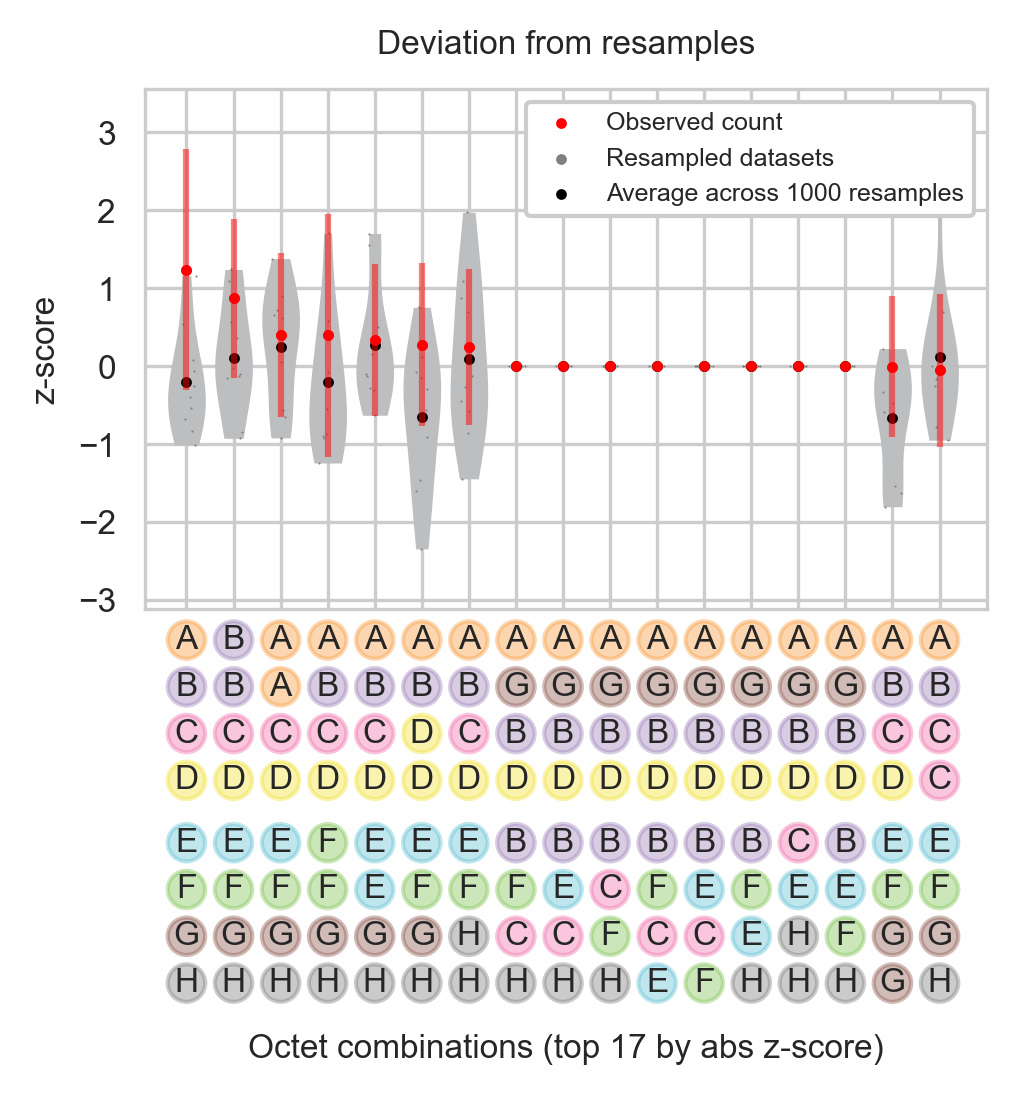

In [394]:
plot_deviation('octet', 
               df_true_melt_subset_c_subtree_m_ss, 
               df_null_zscores_i_c_melt_subset_c_subtree_ss,
               df_null_zscores_i_c_melt_subset_c_subtree_ss,
               cell_color_dict,
               legend_bool=True,
               legend_pos='inside',
               save=True, 
                   image_format='svg',
                   dpi=300,
                   image_save_path='predet_states_model_v02_octet')

In [395]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

subtree_type_list = ['doublet',
                     'quartet', 
                     'octet',
                     ]

index_list = [[1,3], 
              [2,4,8,10], 
              [3,5,9,11,17,19,23,25],
              ]

y_list = [[-0.06, -0.15], 
          [-0.06, -0.15, -0.27, -0.36],
          [-0.06, -0.15, -0.24, -0.33, -0.45, -0.54, -0.63, -0.72],
         ]

df_annotations = pd.DataFrame({'subtree_type': subtree_type_list,
                               'index': index_list,
                               'y': y_list,
                               })
df_annotations

subtree_type                          index  \
0      doublet                         [1, 3]   
1      quartet                  [2, 4, 8, 10]   
2        octet  [3, 5, 9, 11, 17, 19, 23, 25]   

                                                   y  
0                                     [-0.06, -0.15]  
1                       [-0.06, -0.15, -0.27, -0.36]  
2  [-0.06, -0.15, -0.24, -0.33, -0.45, -0.54, -0....

In [396]:
def make_annotation(i, label, subtree_type):
    index_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['index'].values[0]
    y_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['y'].values[0]

    for index, y in zip(index_list_subtree, y_list_subtree):
        c_str = label[index]
        x = i
        ax.add_artist(_make_circle(cell_color_dict[c_str], 4.5, x, y, 0.4))
        ax.annotate(c_str, 
                    xy=(x, y), 
                    verticalalignment="center", 
                    horizontalalignment="center",
                    annotation_clip=False, 
                    xycoords=("data", "axes fraction"),
                    **{'fontname':'Arial', 'size':8})

In [397]:
cell_color_dict = make_color_dict(cell_fates, ['#F89A3A', 
                                               '#9C80B8', 
                                               '#F071AB', 
                                               '#F0E135',
                                               '#5FC0D4', 
                                               '#7EC352',
                                               ]+[colorcet.glasbey_category10[5]]+[colorcet.glasbey_category10[7]])

In [398]:
subtree_list = ['doublet',
                'quartet', 
                'octet'
                ]

subtree_label_list = ['(A,B)',
                      '((A,B),(C,D))',
                      '(((A,B),(C,D)),((E,F),(G,H)))',
                      ]

num_trees_list = [50, 500, 5000, 50000]

meta_list = []

for subtree, subtree_label in zip(subtree_list, subtree_label_list):
    for num_trees in num_trees_list:
        for rep in range(10):
            df_true_melt_subset = pd.read_csv(f'../data/predet_states_model_v02_2/df_true_melt_subset_{subtree}_trees{num_trees}_rep{rep}.csv', index_col=0)
            if subtree_label in df_true_melt_subset['label'].values:
                z_score = df_true_melt_subset.loc[df_true_melt_subset['label']==subtree_label]['z-score'].values[0]
            else:
                z_score = 0
            meta_list.append([subtree, subtree_label, num_trees, rep, z_score])

In [399]:
df_meta = pd.DataFrame(meta_list, columns=['subtree', 'label', 'num_trees', 'rep', 'z_score'])
df_meta

subtree                          label  num_trees  rep    z_score
0    doublet                          (A,B)         50    0  10.397568
1    doublet                          (A,B)         50    1   9.288403
2    doublet                          (A,B)         50    2  12.885643
3    doublet                          (A,B)         50    3  11.563400
4    doublet                          (A,B)         50    4  11.223659
..       ...                            ...        ...  ...        ...
115    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    5   0.732213
116    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    6   0.387733
117    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    7  -0.638266
118    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    8   0.342041
119    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    9   1.230523

[120 rows x 5 columns]

In [400]:
import matplotlib.colors as colors
import cmasher as cmr

cmap = cmr.get_sub_cmap('Greys', 0.3, 1)

In [401]:
df_meta_filt = df_meta#[df_meta['z_score'] > 0]
df_meta_filt['z_score'] += 0.01
df_meta_filt

subtree                          label  num_trees  rep    z_score
0    doublet                          (A,B)         50    0  10.407568
1    doublet                          (A,B)         50    1   9.298403
2    doublet                          (A,B)         50    2  12.895643
3    doublet                          (A,B)         50    3  11.573400
4    doublet                          (A,B)         50    4  11.233659
..       ...                            ...        ...  ...        ...
115    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    5   0.742213
116    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    6   0.397733
117    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    7  -0.628266
118    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    8   0.352041
119    octet  (((A,B),(C,D)),((E,F),(G,H)))      50000    9   1.240523

[120 rows x 5 columns]

0 ('(A,B)', 'doublet')
1 ('((A,B),(C,D))', 'quartet')
2 ('(((A,B),(C,D)),((E,F),(G,H)))', 'octet')


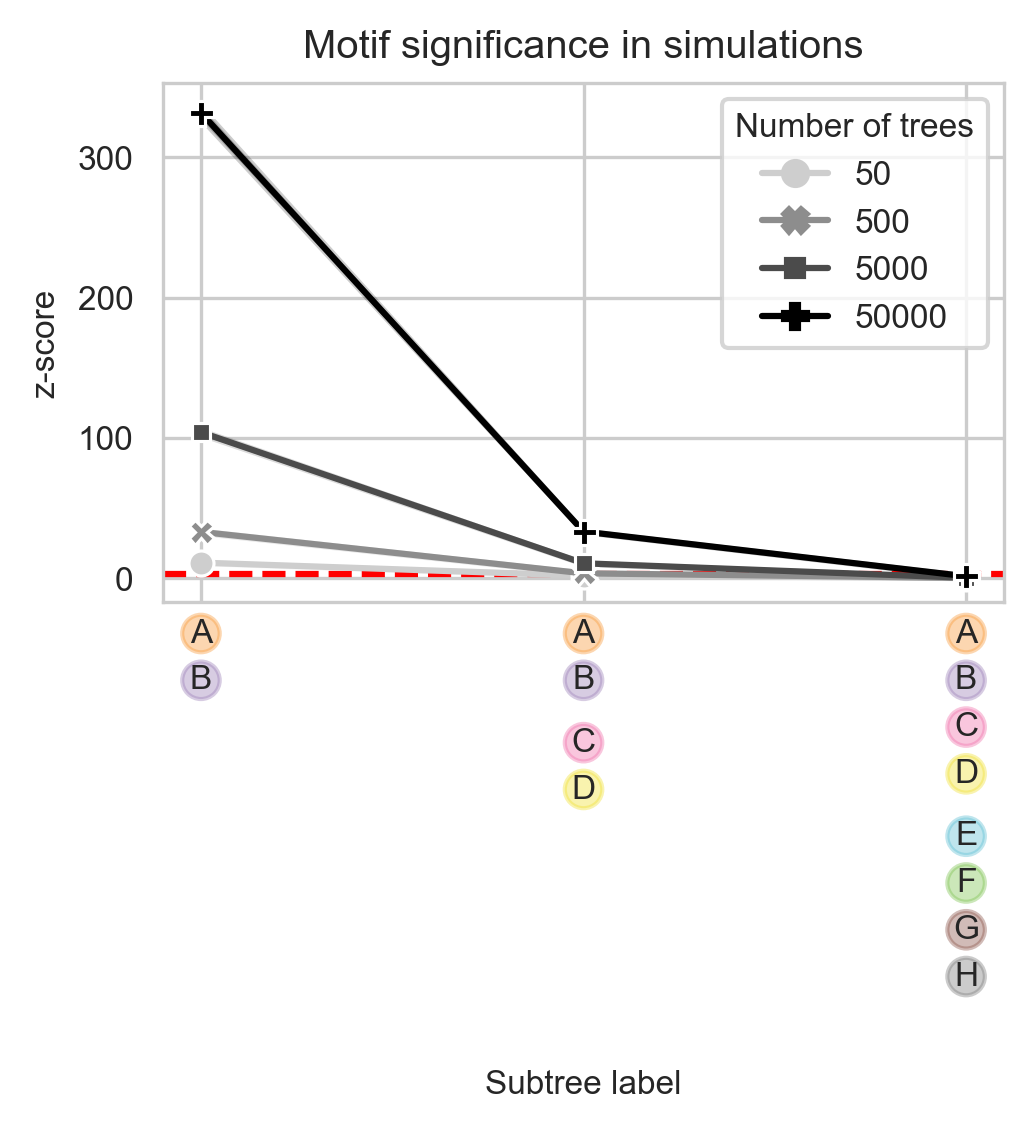

In [402]:
fig, ax = pyplot.subplots(figsize=(0.21*17+0.05,2.25))

pyplot.axhline(y = 3, color = 'r', linestyle = '--')

sns.lineplot(data=df_meta_filt, 
             x='label', 
             y='z_score', 
             hue='num_trees', 
             style="num_trees",
             legend='full', 
             hue_norm=colors.LogNorm(vmin=df_meta['num_trees'].min(), vmax=df_meta['num_trees'].max()),
             markers=True,
             dashes=False,
             palette=cmap
            )       
#pyplot.yscale('log')
pyplot.legend(title='Number of trees', loc='upper right')
ax.set_xticklabels([])

for i, (subtree_label, subtree_type) in enumerate(zip(subtree_label_list, subtree_type_list)):
    print(i, (subtree_label, subtree_type))
    make_annotation(i, subtree_label, subtree_type)

pyplot.ylabel("z-score")
pyplot.xlabel("Subtree label", labelpad=105)
pyplot.title("Motif significance in simulations")

pyplot.savefig(f"predet_states_model_v02_no_logsim_line_plot.svg", dpi=300, bbox_inches="tight")

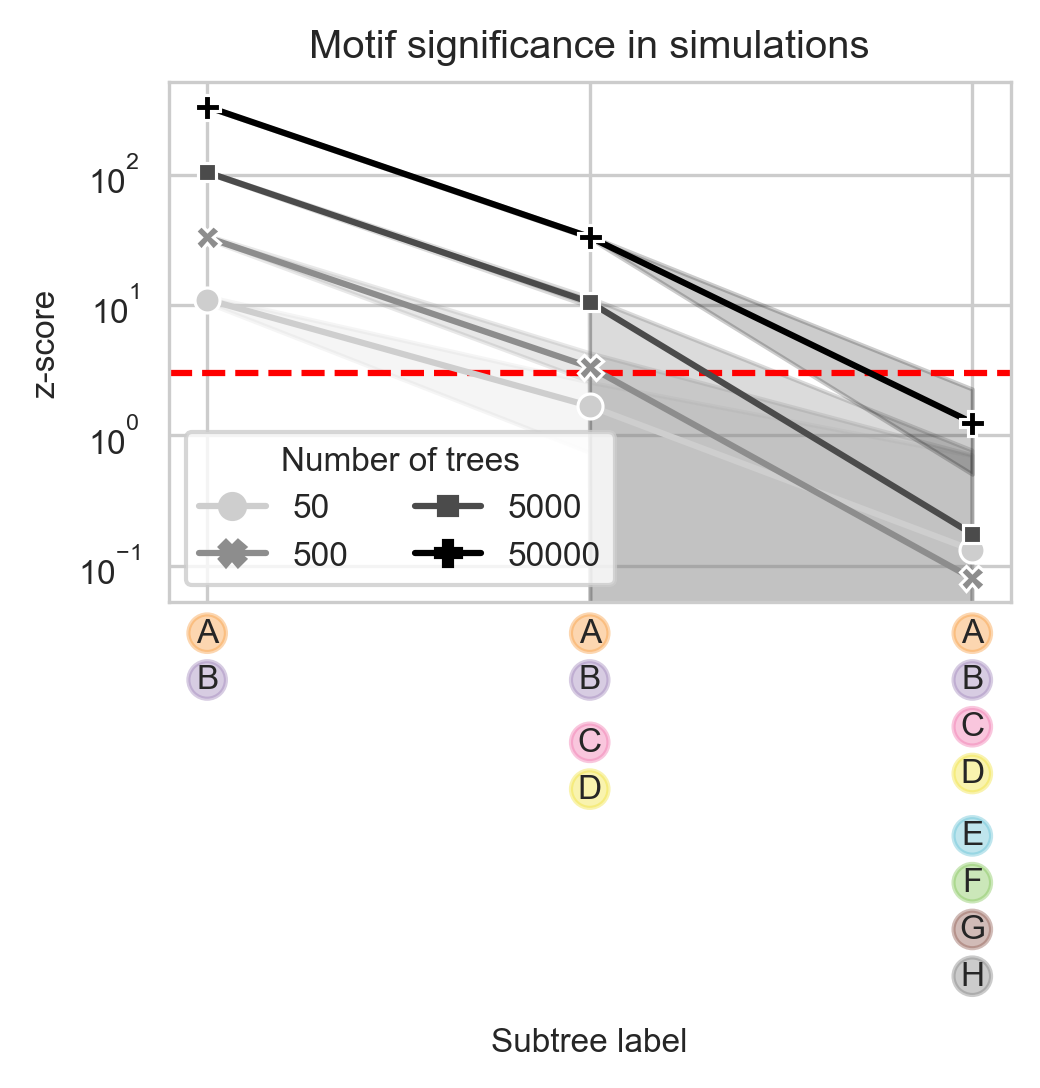

In [405]:
fig, ax = pyplot.subplots(figsize=(0.21*17+0.05,2.25))

pyplot.axhline(y = 3, color = 'r', linestyle = '--')

sns.lineplot(data=df_meta_filt, 
             x='label', 
             y='z_score', 
             hue='num_trees', 
             style="num_trees",
             legend='full', 
             hue_norm=colors.LogNorm(vmin=df_meta['num_trees'].min(), vmax=df_meta['num_trees'].max()),
             markers=True,
             dashes=False,
             palette=cmap
            )       
pyplot.yscale('log')
pyplot.legend(title='Number of trees', loc='lower left', ncol=2)
ax.set_xticklabels([])

for i, (subtree_label, subtree_type) in enumerate(zip(subtree_label_list, subtree_type_list)):
    make_annotation(i, subtree_label, subtree_type)

pyplot.ylabel("z-score")
pyplot.xlabel("Subtree label", labelpad=95)
pyplot.title("Motif significance in simulations")

pyplot.savefig(f"predet_states_model_v02_sim_line_plot.svg", dpi=300, bbox_inches="tight")

In [13]:
num_trees = 50000
rep = 0 
all_trees_sorted = read_dataset(f"../data/predet_states_model_v02_2/trees_trees{num_trees}_rep{rep}.txt")

tree_sizes = [len(re.findall('\w', i)) for i in all_trees_sorted]

In [14]:
np.median(tree_sizes)

16.0

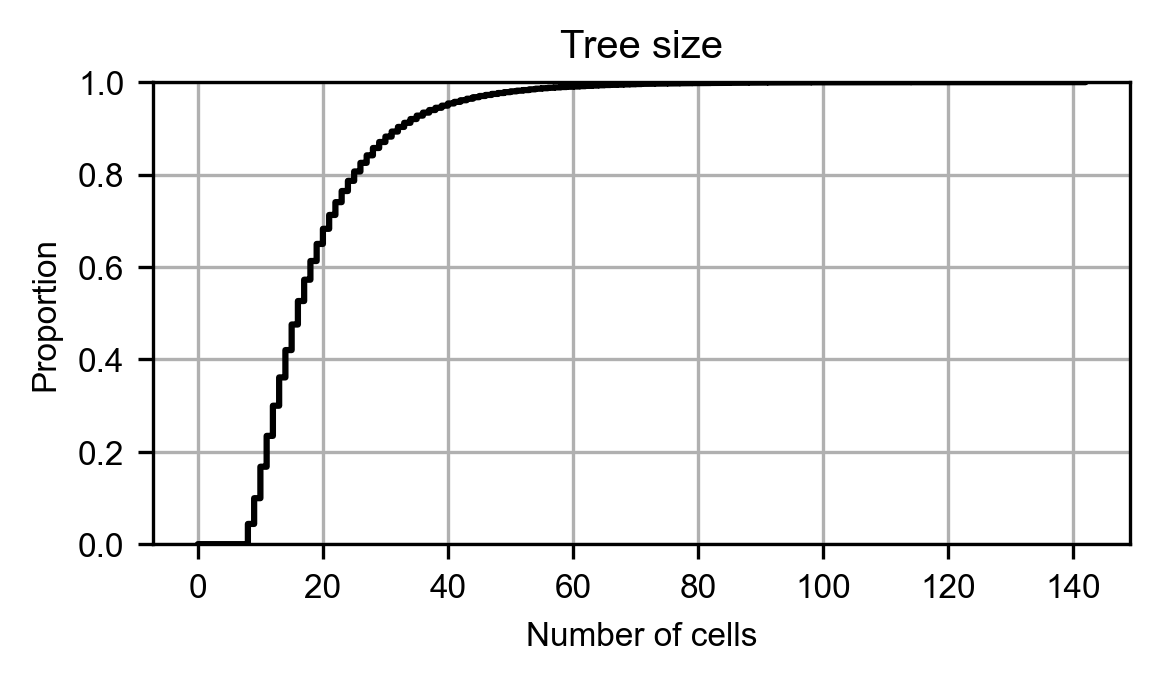

In [15]:
fig, ax = pyplot.subplots(figsize=(4.2, 2))

sns.ecdfplot(tree_sizes, color='black')
pyplot.xlabel("Number of cells")
pyplot.title('Tree size')
pyplot.grid(True)

pyplot.savefig(f"predet_states_model_v02_tree_size.svg", bbox_inches="tight")

## old

In [ ]:
df_meta_hm = df_meta.groupby(['label', 'num_trees'])['z_score'].mean().to_frame().reset_index().pivot(index='num_trees', columns='label', values='z_score')
df_meta_hm

In [ ]:
fig, ax = pyplot.subplots(figsize=(6,3.5))

hm_vals = df_meta_hm.values
significant_cells = [(k, i) for i, j in enumerate(hm_vals) for k, l in enumerate(j) if (l > 3)]
sns.set(font='Arial', font_scale=0.75)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list(colors=sns.color_palette("RdBu", n_colors=512)[256:], name='blues')
my_cmap.set_bad((1,1,1))
g = sns.heatmap(df_meta_hm, 
                annot=True, 
                fmt='.3g', 
                norm=LogNorm(), 
                cmap=my_cmap, 
                cbar_kws={'label': 'z-score'}, 
                linewidths=1, 
                linecolor='lightgray', 
                clip_on=False,
                xticklabels=False)

# add boxes around significant cells
for significant_cell in significant_cells:
    g.add_patch(Rectangle(significant_cell, 1, 1, fill=False, edgecolor='red', lw=2, clip_on=False))  
    
g.invert_yaxis()
g.invert_xaxis()
    
pyplot.ylabel("Number of trees")
pyplot.xlabel("Subtree label", labelpad=110)
pyplot.title("Motif significance in simulations")

pyplot.yticks(rotation=0)

for i, (subtree_label, subtree_type) in enumerate(zip(subtree_label_list[::-1], subtree_type_list[::-1])):
    make_annotation(i, subtree_label, subtree_type)

pyplot.savefig(f"predet_states_model_hm.svg", dpi=300, bbox_inches="tight")

In [ ]:
subtree_label

In [ ]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

In [ ]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

subtree_type_list = ['doublet',
                     'triplet',
                     'quartet', 
                     'asym_quartet',
                     'asym_quintet',
                     'asym_sextet',
                     'asym_septet']

index_list = [[1,3], 
              [1,4,6], 
              [2,4,8,10], 
              [1,4,7,9], 
              [1,4,7,10,12], 
              [1,4,7,10,13,15], 
              [1,4,7,10,13,16,18]
              ]

y_list = [[-0.06, -0.15], 
          [-0.06, -0.18, -0.27],
          [-0.06, -0.15, -0.27, -0.36],
          [-0.06, -0.18, -0.30, -0.39],
          [-0.06, -0.18, -0.30, -0.42, -0.51],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.63],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.66, -0.75]
         ]

labelpad_list = [22.5, 40, 52.5, 60, 80, 100, 120]

df_annotations = pd.DataFrame({'subtree_type': subtree_type_list,
                               'index': index_list,
                               'y': y_list,
                               'labelpad': labelpad_list})
df_annotations

In [ ]:
def make_annotation(label, subtree_type):
    index_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['index'].values[0]
    y_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['y'].values[0]

    for index, y in zip(index_list_subtree, y_list_subtree):
        c_str = label[index]
        x = label
        ax.add_artist(_make_circle(cell_color_dict[c_str], 4.5, x, y, 0.4))
        ax.annotate(c_str, 
                    xy=(x, y), 
                    verticalalignment="center", 
                    horizontalalignment="center",
                    annotation_clip=False, 
                    xycoords=("data", "axes fraction"),
                    **{'fontname':'DejaVu Sans', 'size':8})

In [ ]:
margins=0.05
bbox_to_anchor=(0, 0)  
figsize=(4, 2.5)

sns.set_style('whitegrid')
fig, ax = pyplot.subplots(figsize=figsize)
pyplot.setp(ax.collections)

pyplot.scatter(subtree_label_list, z_score_list, color='red')
pyplot.plot(subtree_label_list, z_score_list, color='red', alpha=0.5)

pyplot.grid(True)
ax.set_xticklabels([])

pyplot.title(f'Motif significance across various subtree sizes', y=1.02, **{'fontname':'DejaVu Sans', 'size':8})#, fontweight='bold')
pyplot.ylabel('z-score', **{'fontname':'DejaVu Sans', 'size':8})
pyplot.yticks(**{'fontname':'DejaVu Sans', 'size':8})

subtree_type_list = ['doublet',
                     'triplet',
                     'asym_quartet',
                     'asym_quintet',
                     'asym_sextet'
                     ]

for subtree_label, subtree_type in zip(subtree_label_list, subtree_type_list):
    make_annotation(subtree_label, subtree_type)

pyplot.xlabel('Subtree label', labelpad=100, **{'fontname':'DejaVu Sans', 'size':8})